In [2]:
# Paso 1: Importación de bibliotecas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (confusion_matrix, roc_auc_score, accuracy_score, 
                            precision_score, recall_score, f1_score, 
                            matthews_corrcoef, cohen_kappa_score)
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, 
                             GradientBoostingClassifier, RandomForestClassifier, 
                             ExtraTreesClassifier)
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau, pointbiserialr
import graphviz
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:25:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Resultados iniciales (validación simple):
             Algorithm  Sensitivity  Specificity  Precision        F1  \
0             AdaBoost     0.750000     0.886364   0.843750  0.794118   
1              Bagging     0.777778     0.931818   0.903226  0.835821   
2                  GBM     0.777778     0.863636   0.823529  0.800000   
3                  ERT     0.777778     0.931818   0.903226  0.835821   
4         RandomForest     0.750000     0.931818   0.900000  0.818182   
5                  XGB     0.777778     0.909091   0.875000  0.823529   
6   LogisticRegression     0.805556     0.954545   0.935484  0.865672   
7           NaiveBayes     0.805556     0.931818   0.906250  0.852941   
8                  MLP     0.972222     0.727273   0.744681  0.843373   
9                  KNN     0.777778     0.909091   0.875000  0.823529   
10                 SVM     0.388889     1.000000   1.000000  0.560000   
11        DecisionTree     0.833333     0.840909   0.810811  0.821918   
12      

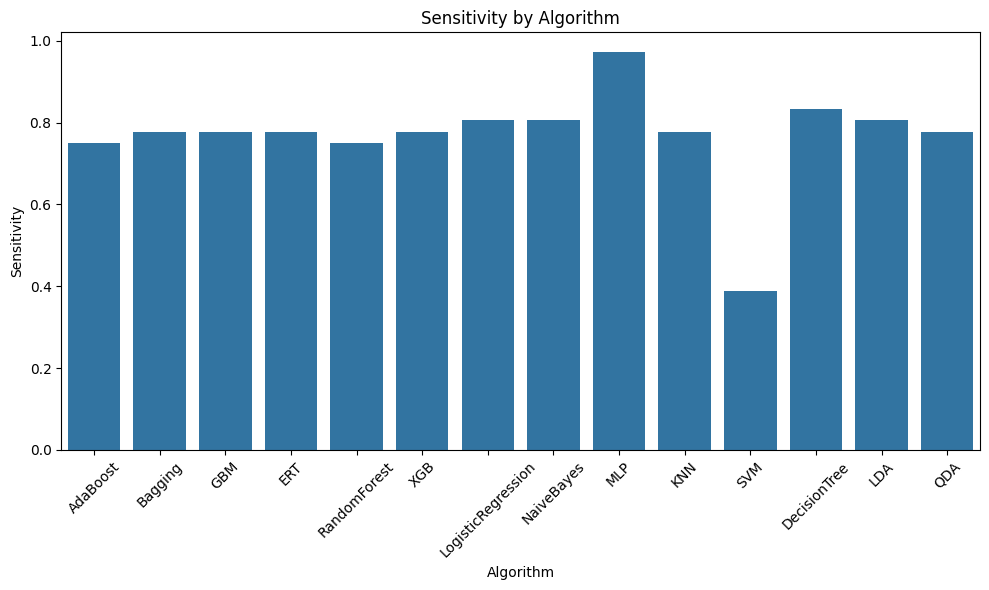

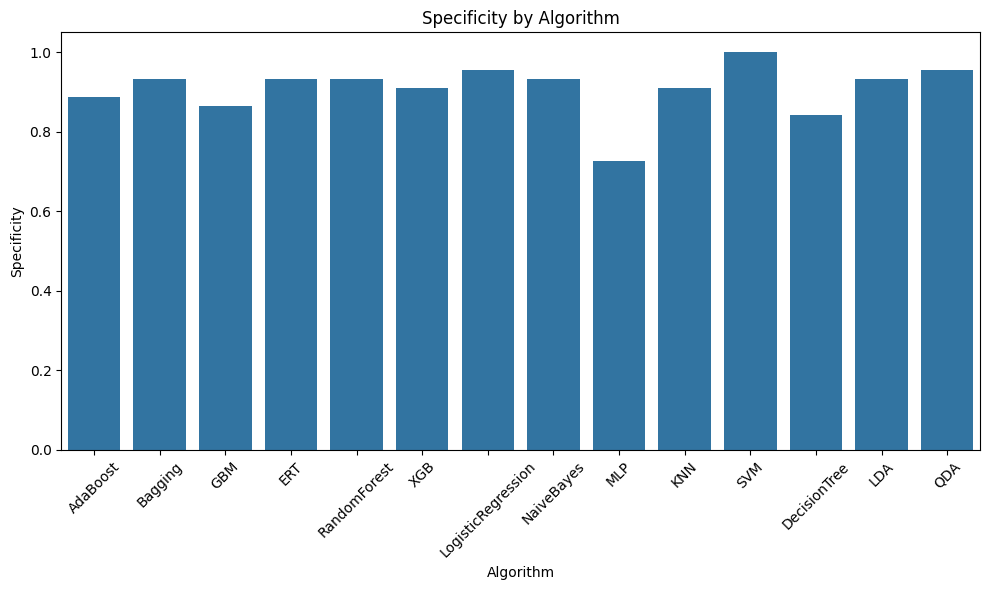

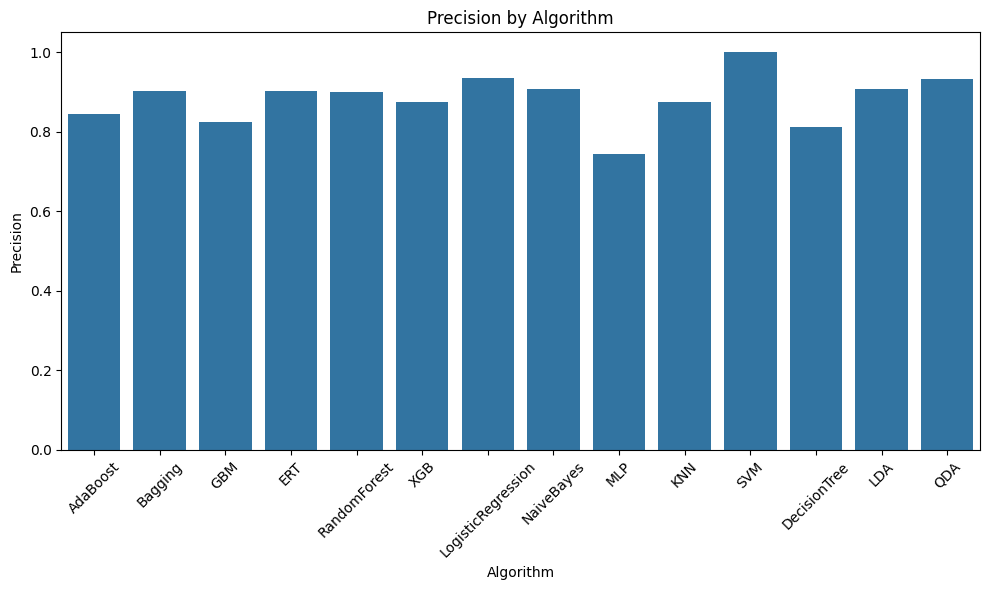

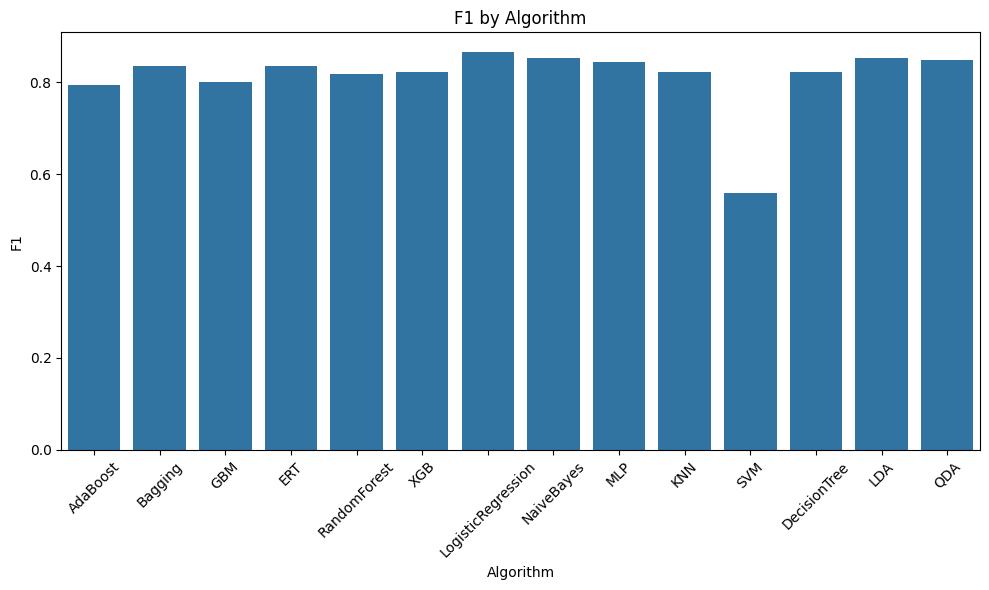

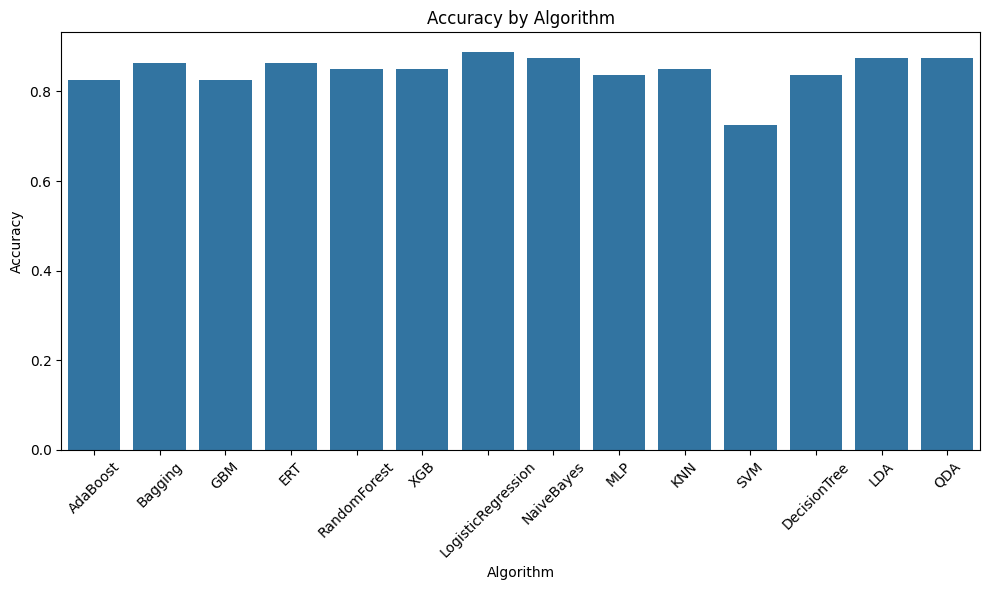

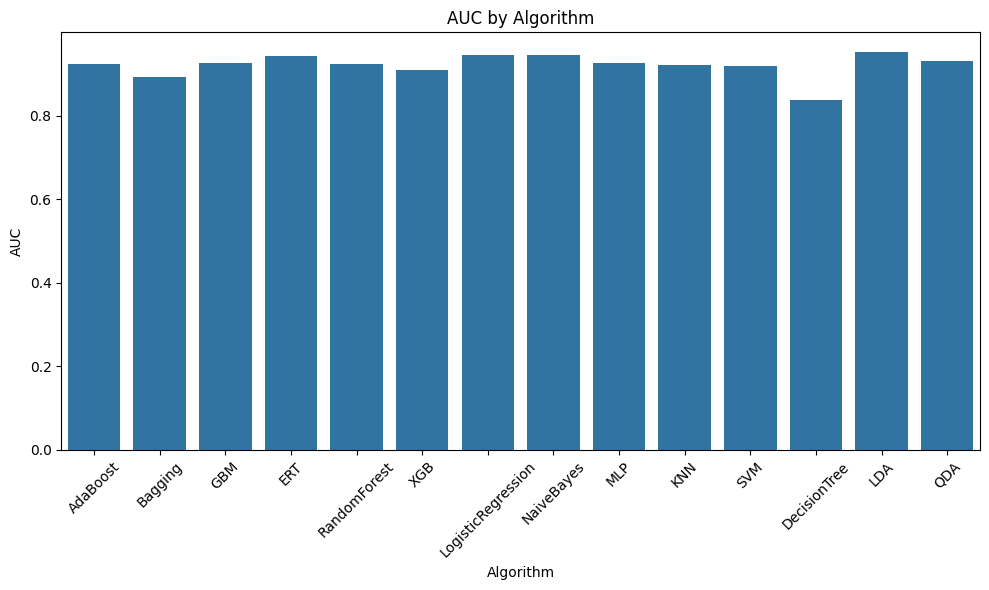

In [3]:
"""# Paso 2: Carga y preparación de datos
df = pd.read_csv("admission_predict.csv")
df["target"] = (df["Chance of Admit "] >= 0.75).astype(int)
df.drop(columns=["Serial No.", "Chance of Admit "], inplace=True)

# División de datos
X = df.drop(columns=["target"])
y = df["target"]

# Primero separamos 20% para test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# Del 80% restante, separamos 25% para validación (20% total) y 75% para entrenamiento (60% total)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Definición de modelos
models = {
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'GBM': GradientBoostingClassifier(),
    'ERT': ExtraTreesClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'DecisionTree': DecisionTreeClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()    
}

# Evaluación inicial con validación simple
results = []
X_train_np = np.ascontiguousarray(X_train.values)
X_valid_np = np.ascontiguousarray(X_valid.values)

for model_label, model in models.items():
    model.fit(X_train_np, y_train)
    y_pred = model.predict(X_valid_np)
    try:
        y_pred_prob = model.predict_proba(X_valid_np)[:, 1]
    except AttributeError:
        y_pred_prob = y_pred
    
    cm = confusion_matrix(y_valid, y_pred)
    sensitivity = recall_score(y_valid, y_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    accuracy = accuracy_score(y_valid, y_pred)
    try:
        auc = roc_auc_score(y_valid, y_pred_prob)
    except:
        auc = np.nan
    
    results.append({
        'Algorithm': model_label,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'F1': f1,
        'Accuracy': accuracy,
        'AUC': auc
    })

df_results = pd.DataFrame(results)
print("\nResultados iniciales:")
print(df_results)

# Visualización inicial
metrics = ['Sensitivity', 'Specificity', 'Precision', 'F1', 'Accuracy', 'AUC']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Algorithm', y=metric, data=df_results)
    plt.title(f'{metric} by Algorithm')
    plt.xticks(rotation=45)
    plt.show()

# Paso 3: Importancia de características
X_imp = X.copy().astype('float64')
y_imp = y.copy()

# Métricas de importancia
chi2_vals, _ = chi2(X_imp, y_imp)
mi_vals = mutual_info_classif(X_imp, y_imp, random_state=42)
anova_vals, _ = f_classif(X_imp, y_imp)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_imp, y_imp)
rfi_vals = rf.feature_importances_

# Otras métricas
auc_vals = []
for col in X_imp.columns:
    try:
        auc = roc_auc_score(y_imp, X_imp[col])
    except:
        auc = np.nan
    auc_vals.append(auc)

kt_vals = [abs(kendalltau(X_imp[col], y_imp).correlation) for col in X_imp.columns]
pcf_vals = [abs(pointbiserialr(X_imp[col], y_imp)[0]) for col in X_imp.columns]
""" 
# ============================
# Paso 2: Carga y preparación de datos
# ============================

# Cargar dataset
df = pd.read_csv("admission_predict.csv")

# Quitar espacios sobrantes en nombres de columnas
df.rename(columns=lambda x: x.strip(), inplace=True)

# Definir variable objetivo binaria (>=0.75 se considera 1)
df["target"] = (df["Chance of Admit"] >= 0.75).astype(int)

# Eliminar columnas no necesarias
df.drop(columns=["Serial No.", "Chance of Admit"], inplace=True)

# Separar variables predictoras y target
X = df.drop(columns=["target"])
y = df["target"]

# División de datos (60% train, 20% valid, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

# ============================
# Paso 3: Definición de modelos
# ============================

models = {
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'GBM': GradientBoostingClassifier(),
    'ERT': ExtraTreesClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'DecisionTree': DecisionTreeClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()
}

# ============================
# Paso 4: Evaluación inicial con validación simple
# ============================

results = []

# Convertir a arrays contiguos para algunos modelos que lo requieren
X_train_np = np.ascontiguousarray(X_train.values)
X_valid_np = np.ascontiguousarray(X_valid.values)

for model_label, model in models.items():
    model.fit(X_train_np, y_train)   # 🔑 Aquí se entrena el modelo
    y_pred = model.predict(X_valid_np)

    # Probabilidades para AUC
    try:
        y_pred_prob = model.predict_proba(X_valid_np)[:, 1]
    except AttributeError:
        try:
            y_pred_prob = model.decision_function(X_valid_np)
            # Normalizar a [0,1]
            y_pred_prob = (y_pred_prob - y_pred_prob.min()) / (y_pred_prob.max() - y_pred_prob.min())
        except:
            y_pred_prob = y_pred  # fallback (menos preciso)

    # Métricas
    cm = confusion_matrix(y_valid, y_pred)
    sensitivity = recall_score(y_valid, y_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else np.nan
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    accuracy = accuracy_score(y_valid, y_pred)
    try:
        auc = roc_auc_score(y_valid, y_pred_prob)
    except:
        auc = np.nan

    results.append({
        'Algorithm': model_label,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'F1': f1,
        'Accuracy': accuracy,
        'AUC': auc
    })

df_results = pd.DataFrame(results)
print("\nResultados iniciales (validación simple):")
print(df_results)

# ============================
# Paso 5: Visualización inicial
# ============================

metrics = ['Sensitivity', 'Specificity', 'Precision', 'F1', 'Accuracy', 'AUC']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Algorithm', y=metric, data=df_results)
    plt.title(f'{metric} by Algorithm')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [4]:
""" # Compilar DataFrame de importancia
importancia_df = pd.DataFrame({
    'Chi²': chi2_vals,
    'GainR': mi_vals,
    'OneR': mi_vals,
    'SU': mi_vals / (X_imp.var().values + 1e-6),
    'IG': mi_vals,
    'Rel': mi_vals,
    'KT': kt_vals,
    'PCF': pcf_vals,
    'Rimp': rfi_vals,
    'Rper': rfi_vals,
    'RFi': rfi_vals,
    'AUC': auc_vals,
    'ANOVA': anova_vals
}, index=X_imp.columns)

# Ranking de importancia
ranking_df = importancia_df.rank(ascending=False)
ranking_df['Mean'] = ranking_df.mean(axis=1)
ranking_df['Rank'] = ranking_df['Mean'].rank()

# Visualización de ranking
plt.figure(figsize=(14, 8))
sns.heatmap(ranking_df.iloc[:, :-2], annot=True, cmap='YlGnBu')
plt.title("Ranking de Importancia de Variables")
plt.tight_layout()
plt.show()
"""



' # Compilar DataFrame de importancia\nimportancia_df = pd.DataFrame({\n    \'Chi²\': chi2_vals,\n    \'GainR\': mi_vals,\n    \'OneR\': mi_vals,\n    \'SU\': mi_vals / (X_imp.var().values + 1e-6),\n    \'IG\': mi_vals,\n    \'Rel\': mi_vals,\n    \'KT\': kt_vals,\n    \'PCF\': pcf_vals,\n    \'Rimp\': rfi_vals,\n    \'Rper\': rfi_vals,\n    \'RFi\': rfi_vals,\n    \'AUC\': auc_vals,\n    \'ANOVA\': anova_vals\n}, index=X_imp.columns)\n\n# Ranking de importancia\nranking_df = importancia_df.rank(ascending=False)\nranking_df[\'Mean\'] = ranking_df.mean(axis=1)\nranking_df[\'Rank\'] = ranking_df[\'Mean\'].rank()\n\n# Visualización de ranking\nplt.figure(figsize=(14, 8))\nsns.heatmap(ranking_df.iloc[:, :-2], annot=True, cmap=\'YlGnBu\')\nplt.title("Ranking de Importancia de Variables")\nplt.tight_layout()\nplt.show()\n'

In [5]:
""" # Paso 4: Visualización de datos
# Gráficos de densidad
df_vis = X.copy()
df_vis["target"] = y.values
numeric_cols = df_vis.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != "target" and df_vis[col].nunique() > 1]

plt.figure(figsize=(12, 5 * ((len(numeric_cols) + 1) // 2)))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot((len(numeric_cols) + 1) // 2, 2, i)
    sns.kdeplot(data=df_vis, x=col, hue="target", fill=False)
    plt.title(f"Densidad: {col}")
plt.tight_layout()
plt.show()

# Gráficos de mosaico para categóricas
categorical_columns = ['University Rating', 'SOP', 'LOR', 'Research', 'target']
df_mosaic = X.copy()
df_mosaic['target'] = y.values
df_mosaic[categorical_columns] = df_mosaic[categorical_columns].astype('category')

fig, axes = plt.subplots(3, 2, figsize=(12, 14))
axes = axes.flatten()
for i, col in enumerate(categorical_columns):
    ax = axes[i]
    if col != 'target':
        prop_df = pd.crosstab(df_mosaic[col], df_mosaic['target'], normalize='index') * 100
        prop_df.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'salmon'], legend=False)
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.text(p.get_x() + p.get_width() / 2., p.get_y() + height / 2.,
                        f'{height:.0f}%', ha="center", va="center", color='black', fontsize=8)
        ax.set_title(col)
    else:
        class_counts = df_mosaic['target'].value_counts(normalize=True) * 100
        class_counts.plot(kind='bar', color=['skyblue', 'salmon'], ax=ax)
        for j, v in enumerate(class_counts):
            ax.text(j, v / 2, f'{v:.0f}%', ha='center', va='center', color='black', fontsize=12)
        ax.set_title("Class Distribution")
plt.tight_layout()
plt.show()
""" 

' # Paso 4: Visualización de datos\n# Gráficos de densidad\ndf_vis = X.copy()\ndf_vis["target"] = y.values\nnumeric_cols = df_vis.select_dtypes(include=["int64", "float64"]).columns.tolist()\nnumeric_cols = [col for col in numeric_cols if col != "target" and df_vis[col].nunique() > 1]\n\nplt.figure(figsize=(12, 5 * ((len(numeric_cols) + 1) // 2)))\nfor i, col in enumerate(numeric_cols, 1):\n    plt.subplot((len(numeric_cols) + 1) // 2, 2, i)\n    sns.kdeplot(data=df_vis, x=col, hue="target", fill=False)\n    plt.title(f"Densidad: {col}")\nplt.tight_layout()\nplt.show()\n\n# Gráficos de mosaico para categóricas\ncategorical_columns = [\'University Rating\', \'SOP\', \'LOR\', \'Research\', \'target\']\ndf_mosaic = X.copy()\ndf_mosaic[\'target\'] = y.values\ndf_mosaic[categorical_columns] = df_mosaic[categorical_columns].astype(\'category\')\n\nfig, axes = plt.subplots(3, 2, figsize=(12, 14))\naxes = axes.flatten()\nfor i, col in enumerate(categorical_columns):\n    ax = axes[i]\n    if c

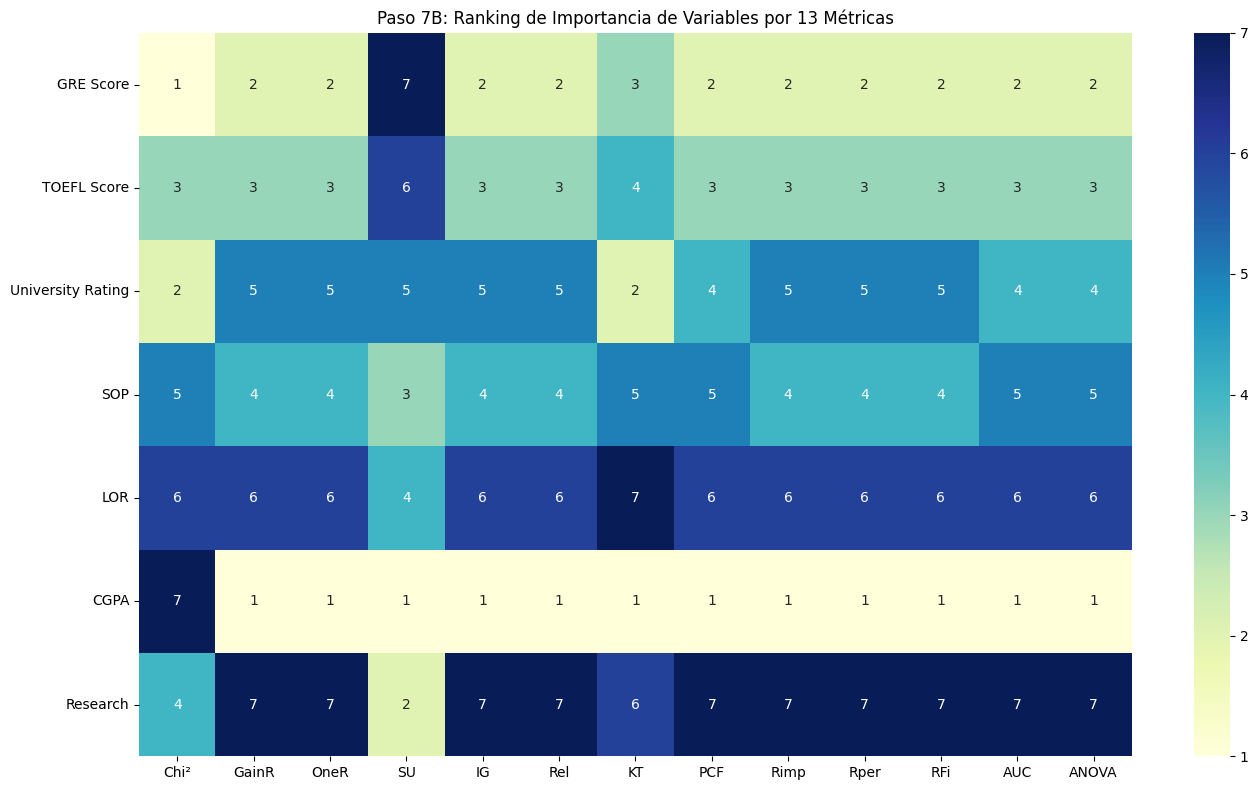

Chi²  GainR  OneR   SU   IG  Rel   KT  PCF  Rimp  Rper  \
CGPA                7.0    1.0   1.0  1.0  1.0  1.0  1.0  1.0   1.0   1.0   
GRE Score           1.0    2.0   2.0  7.0  2.0  2.0  3.0  2.0   2.0   2.0   
TOEFL Score         3.0    3.0   3.0  6.0  3.0  3.0  4.0  3.0   3.0   3.0   
University Rating   2.0    5.0   5.0  5.0  5.0  5.0  2.0  4.0   5.0   5.0   
SOP                 5.0    4.0   4.0  3.0  4.0  4.0  5.0  5.0   4.0   4.0   
LOR                 6.0    6.0   6.0  4.0  6.0  6.0  7.0  6.0   6.0   6.0   
Research            4.0    7.0   7.0  2.0  7.0  7.0  6.0  7.0   7.0   7.0   

                   RFi  AUC  ANOVA      Mean  Rank  
CGPA               1.0  1.0    1.0  1.461538   1.0  
GRE Score          2.0  2.0    2.0  2.384615   2.0  
TOEFL Score        3.0  3.0    3.0  3.307692   3.0  
University Rating  5.0  4.0    4.0  4.307692   4.5  
SOP                4.0  5.0    5.0  4.307692   4.5  
LOR                6.0  6.0    6.0  5.923077   6.0  
Research           7.0  7.0    7.0  6.307692   7.0

In [6]:
# Paso 7: Importancia de las características

# Si hay columnas categóricas, hacer one-hot encoding (en este dataset ya son numéricas)
X_imp = X.copy().astype('float64')
y_imp = y.copy()

# Métricas base
chi2_vals, _ = chi2(X_imp, y_imp)
mi_vals = mutual_info_classif(X_imp, y_imp, random_state=42)
anova_vals, _ = f_classif(X_imp, y_imp)

# Random Forest Importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_imp, y_imp)
rfi_vals = rf.feature_importances_

# AUC por variable
auc_vals = []
for col in X_imp.columns:
    try:
        auc = roc_auc_score(y_imp, X_imp[col])
    except:
        auc = np.nan
    auc_vals.append(auc)

# Kendall Tau
kt_vals = [abs(kendalltau(X_imp[col], y_imp).correlation) for col in X_imp.columns]

# PCF (punto biserial)
pcf_vals = [abs(pointbiserialr(X_imp[col], y_imp)[0]) for col in X_imp.columns]

# Aproximaciones
gainr_vals = mi_vals
oner_vals = mi_vals
su_vals = mi_vals / (X_imp.var().values + 1e-6)
rel_vals = mi_vals
rimp_vals = rfi_vals
rper_vals = rfi_vals

# Compilar métricas en DataFrame
importancia_df = pd.DataFrame({
    'Chi²': chi2_vals,
    'GainR': gainr_vals,
    'OneR': oner_vals,
    'SU': su_vals,
    'IG': mi_vals,
    'Rel': rel_vals,
    'KT': kt_vals,
    'PCF': pcf_vals,
    'Rimp': rimp_vals,
    'Rper': rper_vals,
    'RFi': rfi_vals,
    'AUC': auc_vals,
    'ANOVA': anova_vals
}, index=X_imp.columns)

# Paso 7B: Ranking de métricas
ranking_df = importancia_df.rank(ascending=False)
ranking_df['Mean'] = ranking_df.mean(axis=1)
ranking_df['Rank'] = ranking_df['Mean'].rank()

# Exportar a CSV en la carpeta actual
ranking_df.sort_values("Rank").to_csv("ranking_importancia_metricas_admisiones.csv")

# Visualización del ranking
plt.figure(figsize=(14, 8))
sns.heatmap(ranking_df.iloc[:, :-2], annot=True, cmap='YlGnBu')
plt.title("Paso 7B: Ranking de Importancia de Variables por 13 Métricas")
plt.tight_layout()
plt.show()

# Mostrar tabla ordenada
ranking_df.sort_values("Rank")


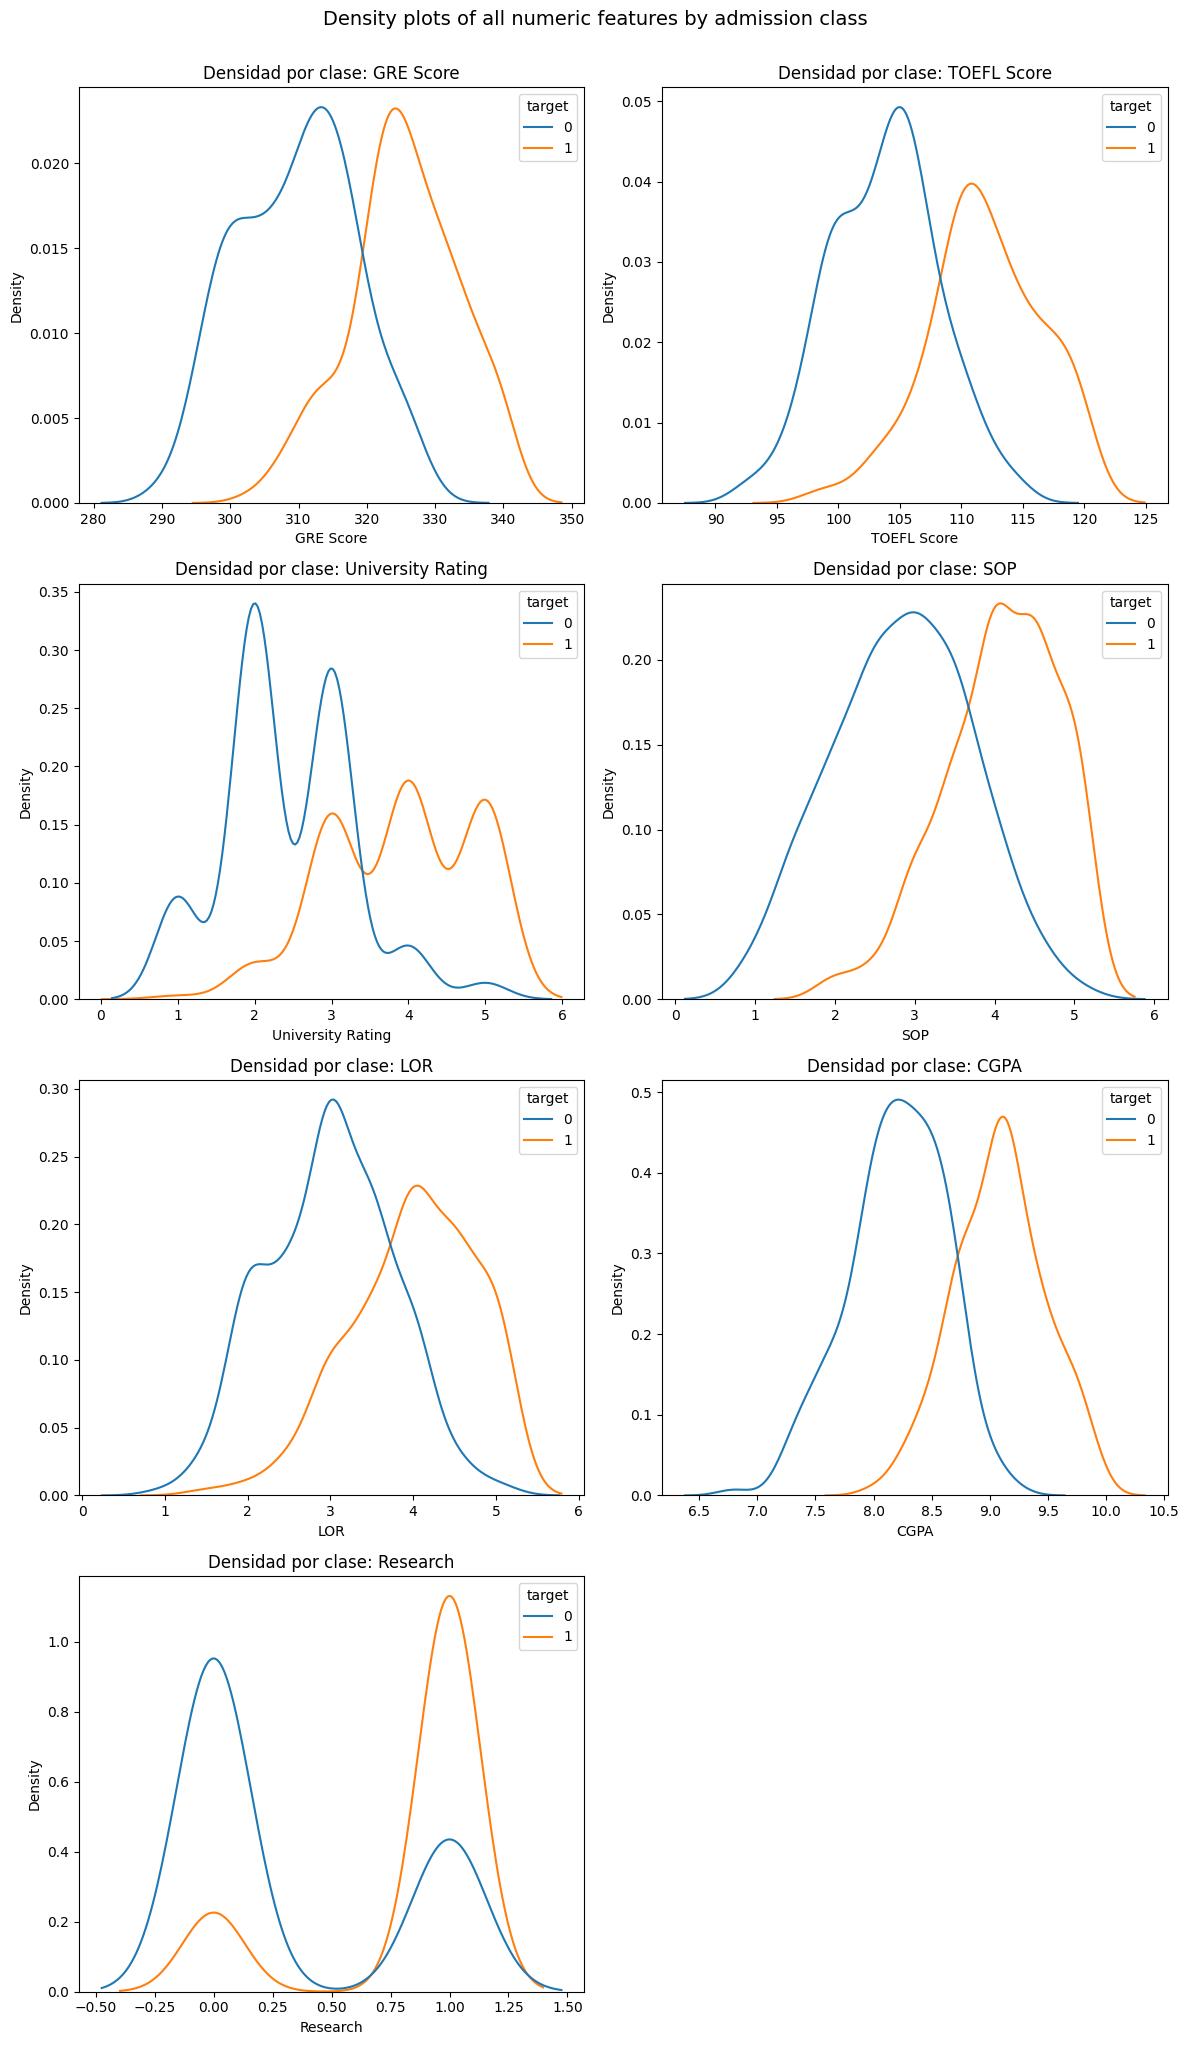

In [7]:
# Paso 7C: Gráficos de densidad de todas las características numéricas por clase

# Crear una copia para visualización
df_vis = X.copy()
df_vis["target"] = y.values

# Seleccionar solo columnas numéricas (excluyendo binarias o categóricas disfrazadas)
numeric_cols = df_vis.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != "target" and df_vis[col].nunique() > 1]

# Crear gráficos
n = len(numeric_cols)
cols = 2
rows = (n + 1) // cols

plt.figure(figsize=(12, 5 * rows))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, i)
    sns.kdeplot(data=df_vis, x=col, hue="target", fill=False)
    plt.title(f"Densidad por clase: {col}")

plt.tight_layout()
plt.suptitle("Density plots of all numeric features by admission class", fontsize=14, y=1.02)
plt.show()

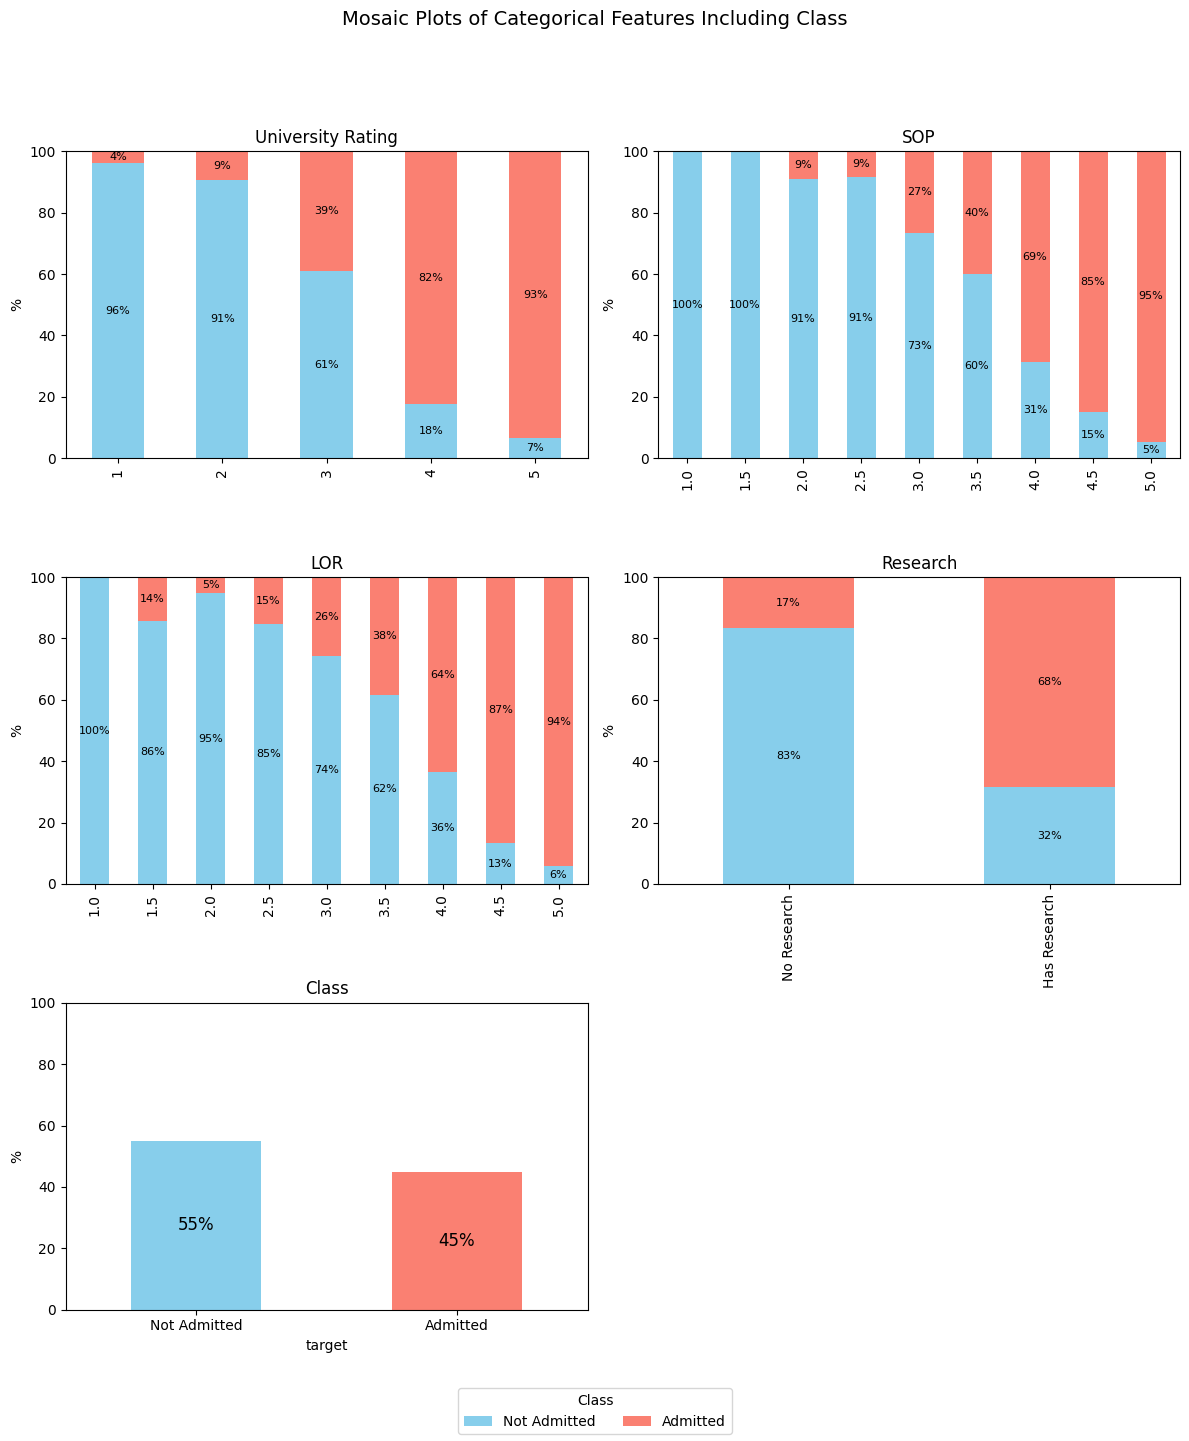

In [8]:
# Paso 7D: Gráficos tipo mosaico para variables categóricas del dataset de admisión

# Crear una copia del DataFrame
df_mosaic = X.copy()
df_mosaic.columns = df_mosaic.columns.str.strip()  # Eliminar espacios
df_mosaic['target'] = y.values

# Verificamos nombres corregidos
# print(df_mosaic.columns.tolist())  # Opcional: verificar visualmente

# Seleccionar variables categóricas
categorical_columns_mosaic = ['University Rating', 'SOP', 'LOR', 'Research', 'target']

# Convertir a tipo categoría
df_mosaic[categorical_columns_mosaic] = df_mosaic[categorical_columns_mosaic].astype('category')

# Renombrar categorías para visualización
try:
    df_mosaic['Research'] = df_mosaic['Research'].cat.rename_categories({0: 'No Research', 1: 'Has Research'})
    df_mosaic['target'] = df_mosaic['target'].cat.rename_categories({0: 'Not Admitted', 1: 'Admitted'})
except:
    pass

# Crear los gráficos
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))
axes = axes.flatten()

for i, col in enumerate(categorical_columns_mosaic):
    ax = axes[i]
    if col != 'target':
        prop_df = pd.crosstab(df_mosaic[col], df_mosaic['target'], normalize='index') * 100
        prop_df.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'salmon'], legend=False)
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.text(p.get_x() + p.get_width() / 2., p.get_y() + height / 2.,
                        f'{height:.0f}%', ha="center", va="center", color='black', fontsize=8)
        ax.set_title(col)
        ax.set_ylabel('%')
        ax.set_xlabel('')
        ax.set_ylim(0, 100)
    else:
        class_counts = df_mosaic['target'].value_counts(normalize=True) * 100
        class_counts.plot(kind='bar', color=['skyblue', 'salmon'], ax=ax)
        for j, v in enumerate(class_counts):
            ax.text(j, v / 2, f'{v:.0f}%', ha='center', va='center', color='black', fontsize=12)
        ax.set_title("Class")
        ax.set_ylabel('%')
        ax.set_xticklabels(class_counts.index, rotation=0)
        ax.set_ylim(0, 100)

# Eliminar ejes no usados
for j in range(len(categorical_columns_mosaic), len(axes)):
    fig.delaxes(axes[j])

# Agregar leyenda
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Class", loc='lower center', ncol=2)
plt.suptitle('Mosaic Plots of Categorical Features Including Class', fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.show()

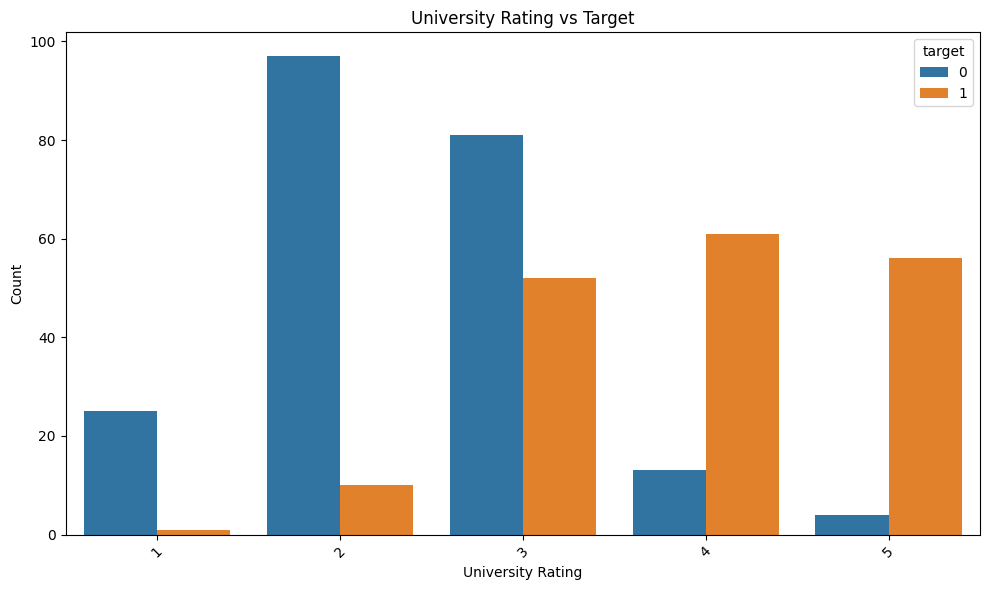

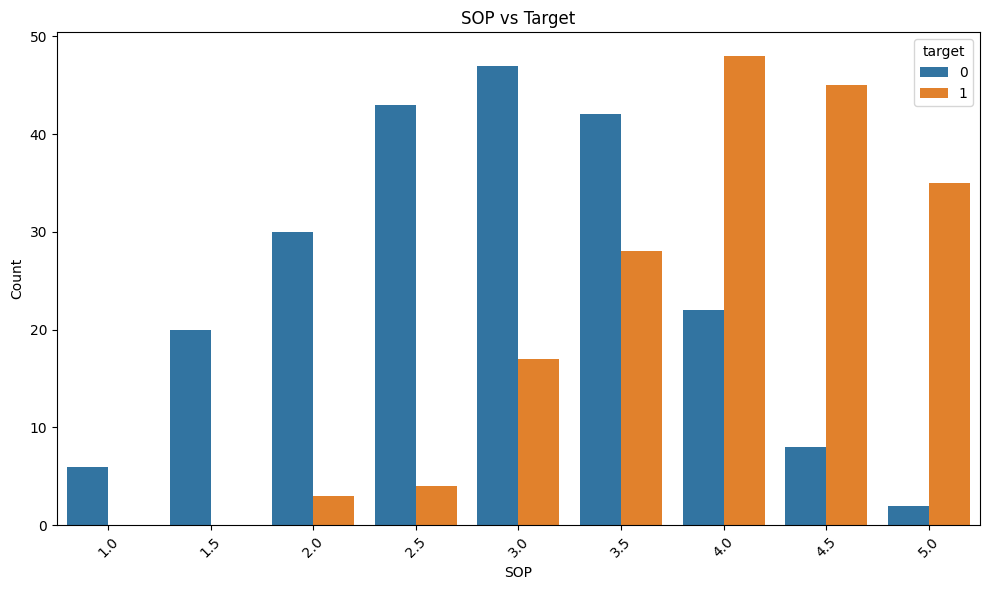

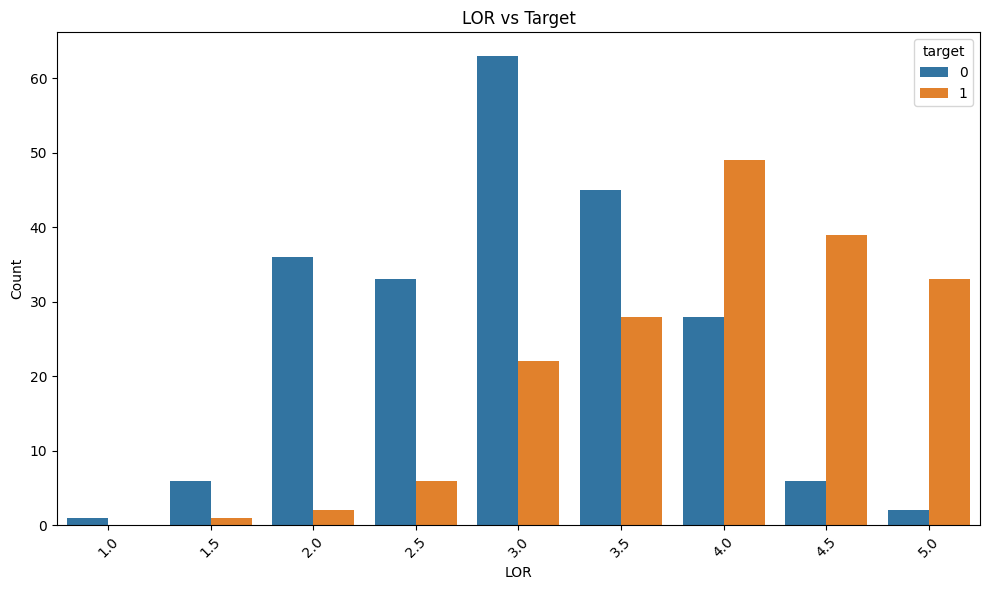

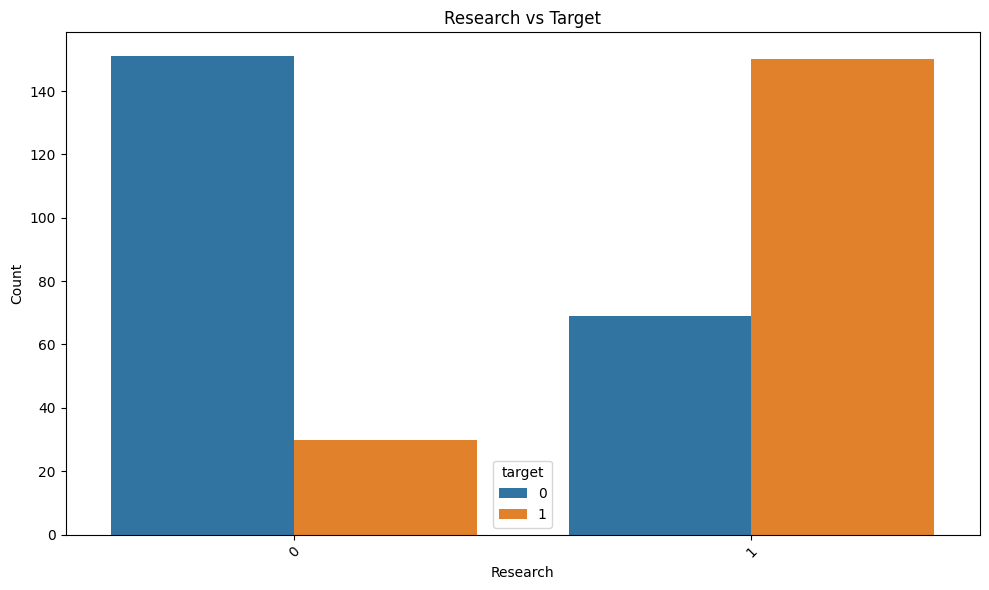

In [9]:
# Paso 8: Gráficos de variables categóricas vs target

# Crear DataFrame visual
df_vis = X.copy()
df_vis.columns = df_vis.columns.str.strip()  # Asegurar nombres limpios
df_vis['target'] = y.astype(str)  # Para usar en hue

# Definir variables categóricas del dataset de admisión
categorical_columns = ['University Rating', 'SOP', 'LOR', 'Research']

# Graficar cada variable frente al target
for col in categorical_columns:
    if col in df_vis.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, hue='target', data=df_vis)
        plt.title(f'{col} vs Target')
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

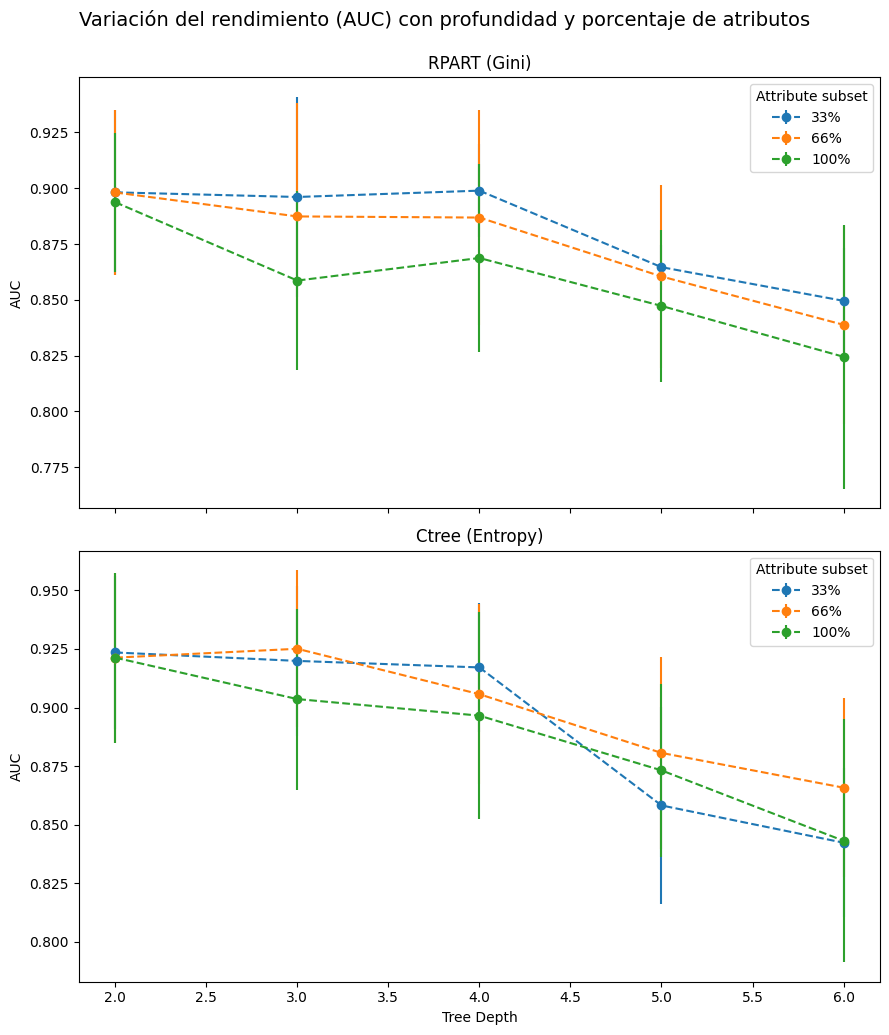

In [10]:
# Paso 8.1: Rendimiento (AUC) con profundidad y porcentaje de atributos

# Obtener importancia de variables desde Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Definir subconjuntos de variables
n_total = len(importances)
n_33 = int(np.ceil(n_total * 0.33))
n_66 = int(np.ceil(n_total * 0.66))

best_33 = importances.head(n_33).index.tolist()
best_66 = importances.head(n_66).index.tolist()
best_100 = importances.index.tolist()

# Crear DataFrames
df_vis = X.copy()
df_vis['target'] = y.values

df_33 = df_vis[best_33 + ['target']]
df_66 = df_vis[best_66 + ['target']]
df_100 = df_vis.copy()

attribute_sets = {
    '33%': df_33,
    '66%': df_66,
    '100%': df_100
}

depths = [2, 3, 4, 5, 6]
results_rpart = []
results_ctree = []

for name, dataset in attribute_sets.items():
    X_sub = pd.get_dummies(dataset.drop('target', axis=1), drop_first=True).astype('float64')
    y_sub = dataset['target'].astype(int)

    for depth in depths:
        # RPART (gini)
        rpart = DecisionTreeClassifier(max_depth=depth, criterion='gini', random_state=42)
        rpart_scores = cross_val_score(rpart, X_sub, y_sub, cv=5, scoring='roc_auc')
        results_rpart.append({
            'Subset': name,
            'Depth': depth,
            'AUC': np.mean(rpart_scores),
            'Std': np.std(rpart_scores)
        })

        # Ctree (entropy)
        ctree = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
        ctree_scores = cross_val_score(ctree, X_sub, y_sub, cv=5, scoring='roc_auc')
        results_ctree.append({
            'Subset': name,
            'Depth': depth,
            'AUC': np.mean(ctree_scores),
            'Std': np.std(ctree_scores)
        })

rpart_df = pd.DataFrame(results_rpart)
ctree_df = pd.DataFrame(results_ctree)

# Gráfica final
fig, axes = plt.subplots(2, 1, figsize=(9, 10), sharex=True)

for subset in rpart_df['Subset'].unique():
    data = rpart_df[rpart_df['Subset'] == subset]
    axes[0].errorbar(data['Depth'], data['AUC'], yerr=data['Std'], label=subset,
                     linestyle='dashed', marker='o')
axes[0].set_title("RPART (Gini)")
axes[0].set_ylabel("AUC")
axes[0].legend(title="Attribute subset")

for subset in ctree_df['Subset'].unique():
    data = ctree_df[ctree_df['Subset'] == subset]
    axes[1].errorbar(data['Depth'], data['AUC'], yerr=data['Std'], label=subset,
                     linestyle='dashed', marker='o')
axes[1].set_title("Ctree (Entropy)")
axes[1].set_xlabel("Tree Depth")
axes[1].set_ylabel("AUC")
axes[1].legend(title="Attribute subset")

plt.tight_layout()
plt.suptitle("Variación del rendimiento (AUC) con profundidad y porcentaje de atributos", fontsize=14, y=1.03)
plt.show()



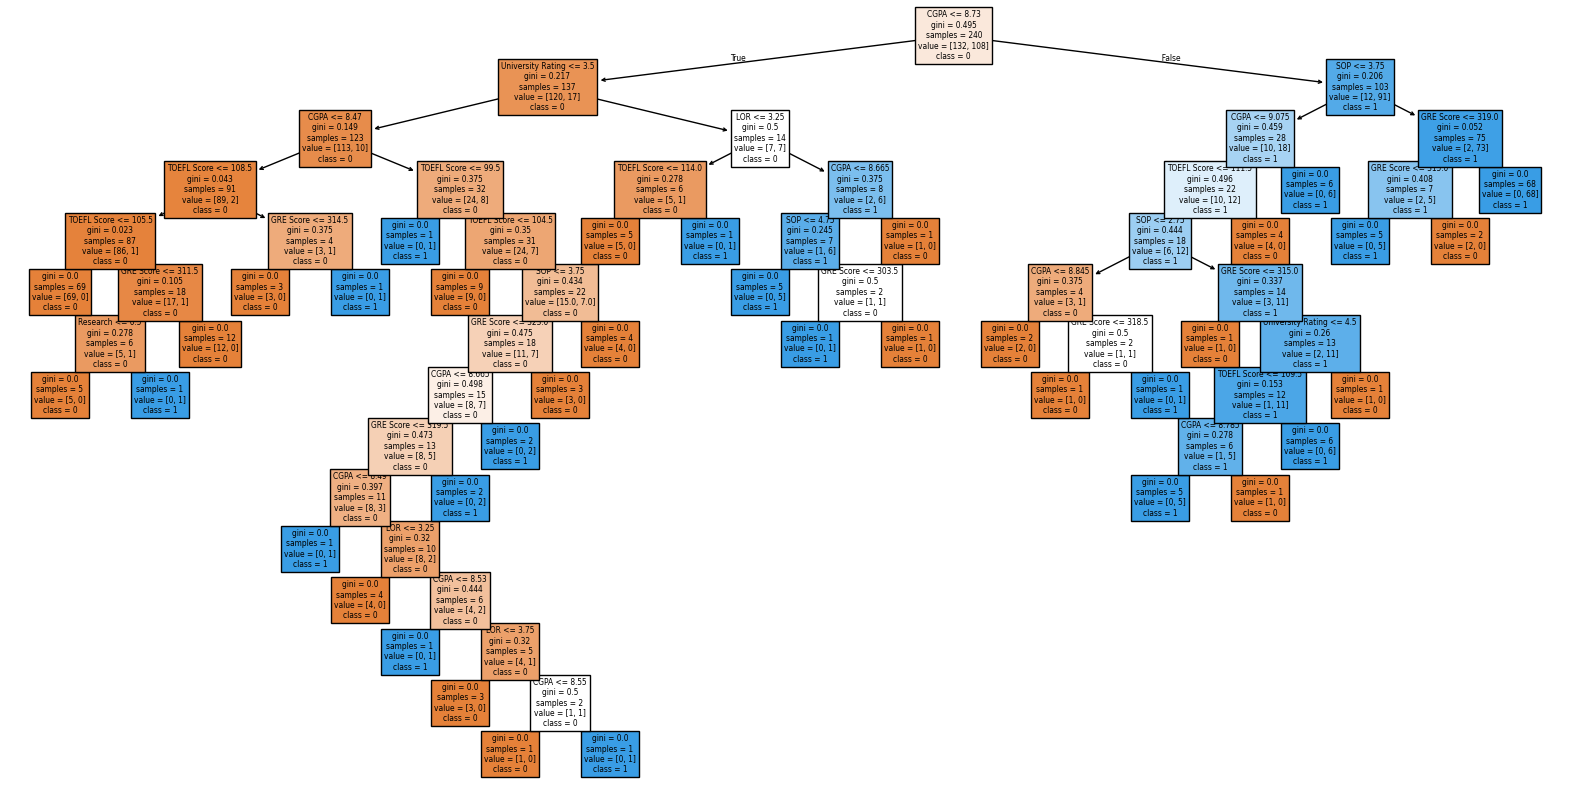

In [11]:
# Paso 9: Árbol de decisión
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=list(X_train.columns), class_names=['0', '1'])
plt.show()

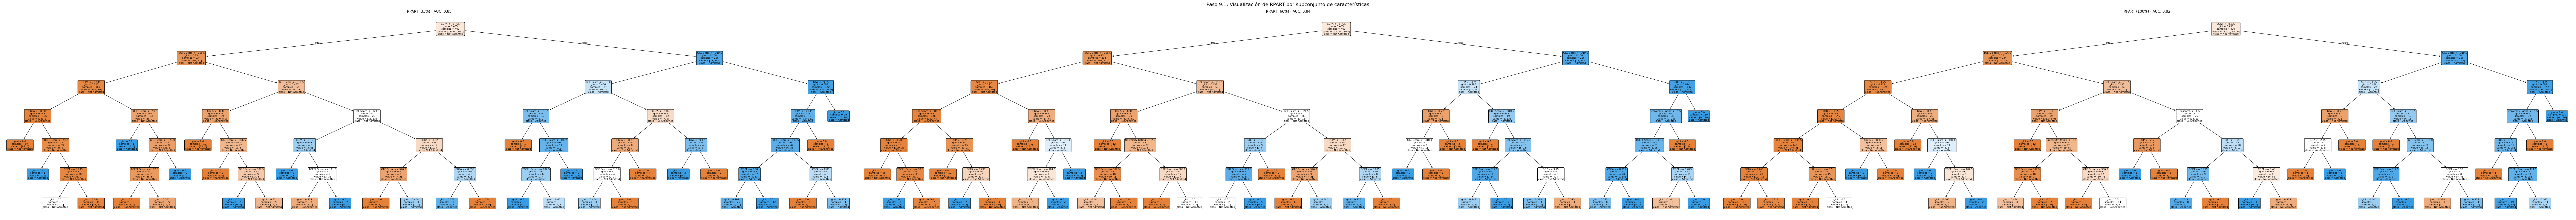

In [12]:
# Paso 9.1: Visualización de RPART con 33%, 66% y 100% de características (max_depth=6)

fig, axes = plt.subplots(1, 3, figsize=(120, 10))

attribute_sets = {
    '33%': df_33,
    '66%': df_66,
    '100%': df_100
}

rpart_auc_scores = {}

for ax, (name, dataset) in zip(axes, attribute_sets.items()):
    X_rpart = pd.get_dummies(dataset.drop('target', axis=1), drop_first=True).astype('float64')
    y_rpart = dataset['target'].astype(int)

    model = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
    model.fit(X_rpart, y_rpart)

    auc = cross_val_score(model, X_rpart, y_rpart, cv=5, scoring='roc_auc').mean()
    rpart_auc_scores[name] = auc

    plot_tree(
        model,
        feature_names=list(X_rpart.columns),
        class_names=['Not Admitted', 'Admitted'],
        filled=True,
        rounded=True,
        fontsize=8,
        ax=ax
    )
    ax.set_title(f"RPART ({name}) - AUC: {auc:.2f}")

plt.tight_layout()
plt.suptitle("Paso 9.1: Visualización de RPART por subconjunto de características", fontsize=16, y=1.02)
plt.show()


In [13]:
from sklearn.tree import export_graphviz
import graphviz

# Datos: Top 33% variables
X_33 = pd.get_dummies(df_33.drop('target', axis=1), drop_first=True).astype('float64')
y_33 = df_33['target'].astype(int)

# Modelo RPART
model_33 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_33.fit(X_33, y_33)

# Exportar como .dot con estilo académico
dot_data_33 = export_graphviz(
    model_33,
    out_file=None,
    feature_names=X_33.columns,
    class_names=['Not Admitted', 'Admitted'],
    filled=True,
    rounded=True,
    special_characters=True,
    proportion=True,
    precision=2
)

# Crear gráfico con Graphviz y exportar como PNG
graph_33 = graphviz.Source(dot_data_33)
graph_33.render("tree_admission_33pct_clean", format="png", cleanup=False)  # crea 'tree_admission_33pct_clean.png'
graph_33.view()

'tree_admission_33pct_clean.pdf'

In [14]:
# Preparar df_66 con top 66% de variables más importantes
n_66 = int(np.ceil(len(importances) * 0.66))
top_66 = importances.head(n_66).index.tolist()

df_66 = X[top_66].copy()
df_66['target'] = y.values

# Preparar datos
X_66 = pd.get_dummies(df_66.drop('target', axis=1), drop_first=True).astype('float64')
y_66 = df_66['target'].astype(int)

# Entrenar modelo RPART con profundidad 3
model_66_depth3 = DecisionTreeClassifier(max_depth=3, criterion='gini', random_state=42)
model_66_depth3.fit(X_66, y_66)

# Exportar con estilo académico
dot_data_66_d3 = export_graphviz(
    model_66_depth3,
    out_file=None,
    feature_names=X_66.columns,
    class_names=['Not Admitted', 'Admitted'],
    filled=True,
    rounded=True,
    special_characters=True,
    proportion=True,
    precision=2
)

# Crear gráfico y exportar como PNG
graph_66_d3 = graphviz.Source(dot_data_66_d3)
output_path_66_d3 = "/mnt/data/arbol_admision_66pct_depth3"
graph_66_d3.render(output_path_66_d3, format="png", cleanup=False)
output_path_66_d3 + ".png"

'/mnt/data/arbol_admision_66pct_depth3.png'

In [15]:
from sklearn.tree import export_graphviz
import graphviz

# 100%
X_100 = pd.get_dummies(df_100.drop('target', axis=1), drop_first=True).astype('float64')
y_100 = df_100['target'].astype('category').cat.codes

# Reemplazar caracteres conflictivos en nombres de columnas
X_100.columns = X_100.columns.str.replace("&", "and").str.replace(">", "gt").str.replace("<", "lt")

model_100 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_100.fit(X_100, y_100)

dot_data_100 = export_graphviz(
    model_100,
    out_file=None,
    feature_names=X_100.columns,
    class_names=['Healthy', 'Heart Disease'],
    filled=True,
    rounded=True,
    special_characters=True
)

graph_100 = graphviz.Source(dot_data_100)
graph_100.render("tree_100", format="png", cleanup=False)
graph_100.view()

'tree_100.pdf'

In [16]:
''' # Paso 10: Evaluación con subconjuntos de atributos (33%, 66%, 100%)

# Asegurar que los conjuntos están listos
datasets = {
    '33%': df_33,
    '66%': df_66,
    '100%': df_100
}

results_all = []

for name, dataset in datasets.items():
    X_eval = pd.get_dummies(dataset.drop('target', axis=1), drop_first=True).astype('float64')
    y_eval = dataset['target'].astype(int)

    X_train, X_valid, y_train, y_valid = train_test_split(X_eval, y_eval, test_size=0.25, random_state=42)

    X_train_np = np.ascontiguousarray(X_train.values)
    X_valid_np = np.ascontiguousarray(X_valid.values)

    for model_label, model in models.items():
        model.fit(X_train_np, y_train)
        result = metricas(model, model_label, X_train_np, X_valid_np, y_train, y_valid)
        result['Subset'] = name
        results_all.append(result)

# Convertir a DataFrame final
df_results_all = pd.DataFrame(results_all)

# Visualización comparativa por métrica
for metric in ['Sensitivity', 'Specificity', 'Precision', 'F1', 'Accuracy', 'AUC']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Algorithm', y=metric, hue='Subset', data=df_results_all)
    plt.title(f'{metric} by Algorithm and Attribute Subset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

''' 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd

def repeated_cv_metrics(model, X, y, n_repeats=10, n_splits=5, random_state=42):
    """
    Evalúa un modelo con validación cruzada estratificada repetida.
    Retorna un DataFrame con las métricas de cada fold.
    """
    rkf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    metrics_list = []

    for fold, (train_idx, test_idx) in enumerate(rkf.split(X, y), 1):
        X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_valid = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)

        # Probabilidades para AUC
        try:
            y_prob = model.predict_proba(X_valid)[:, 1]
        except AttributeError:
            try:
                y_prob = model.decision_function(X_valid)
                # Normalizar a [0,1]
                y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
            except:
                y_prob = y_pred  # último recurso

        # Matriz de confusión para specificity
        cm = confusion_matrix(y_valid, y_pred)
        specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else np.nan

        # Métricas
        metrics_list.append({
            'fold': fold,
            'accuracy': accuracy_score(y_valid, y_pred),
            'recall': recall_score(y_valid, y_pred),  # Sensitivity
            'precision': precision_score(y_valid, y_pred),
            'f1': f1_score(y_valid, y_pred),
            'specificity': specificity,
            'auc': roc_auc_score(y_valid, y_prob) if len(np.unique(y_valid)) > 1 else np.nan
        })

    return pd.DataFrame(metrics_list)



Evaluando AdaBoost con subconjunto 33%
Evaluando Bagging con subconjunto 33%
Evaluando GBM con subconjunto 33%
Evaluando ERT con subconjunto 33%
Evaluando RandomForest con subconjunto 33%
Evaluando XGB con subconjunto 33%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:26:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:26:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:26:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:26:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Evaluando LogisticRegression con subconjunto 33%
Evaluando NaiveBayes con subconjunto 33%
Evaluando MLP con subconjunto 33%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\User

Evaluando KNN con subconjunto 33%
Evaluando SVM con subconjunto 33%
Evaluando DecisionTree con subconjunto 33%
Evaluando LDA con subconjunto 33%
Evaluando QDA con subconjunto 33%
Evaluando AdaBoost con subconjunto 66%
Evaluando Bagging con subconjunto 66%
Evaluando GBM con subconjunto 66%
Evaluando ERT con subconjunto 66%
Evaluando RandomForest con subconjunto 66%
Evaluando XGB con subconjunto 66%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:27:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:27:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:27:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:27:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Evaluando LogisticRegression con subconjunto 66%
Evaluando NaiveBayes con subconjunto 66%
Evaluando MLP con subconjunto 66%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluando KNN con subconjunto 66%
Evaluando SVM con subconjunto 66%
Evaluando DecisionTree con subconjunto 66%
Evaluando LDA con subconjunto 66%
Evaluando QDA con subconjunto 66%
Evaluando AdaBoost con subconjunto 100%
Evaluando Bagging con subconjunto 100%
Evaluando GBM con subconjunto 100%
Evaluando ERT con subconjunto 100%
Evaluando RandomForest con subconjunto 100%
Evaluando XGB con subconjunto 100%


c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:29:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:29:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:29:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [10:29:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Evaluando LogisticRegression con subconjunto 100%
Evaluando NaiveBayes con subconjunto 100%
Evaluando MLP con subconjunto 100%
Evaluando KNN con subconjunto 100%
Evaluando SVM con subconjunto 100%
Evaluando DecisionTree con subconjunto 100%
Evaluando LDA con subconjunto 100%
Evaluando QDA con subconjunto 100%


C:\Users\americasys\AppData\Local\Temp\ipykernel_28976\686355642.py:64: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


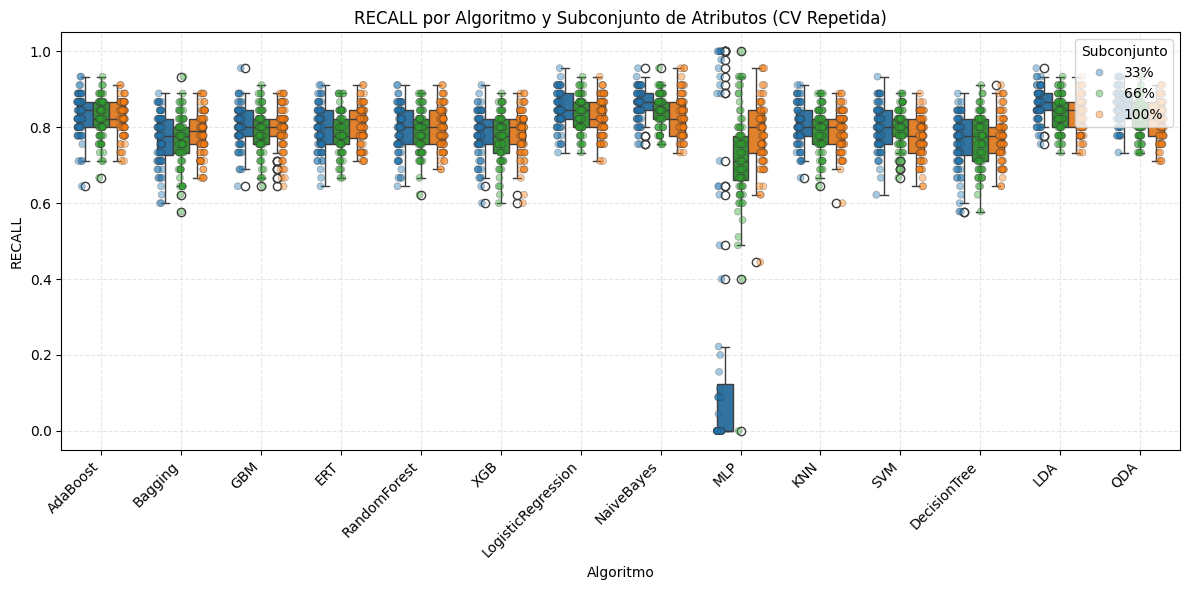

C:\Users\americasys\AppData\Local\Temp\ipykernel_28976\686355642.py:64: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


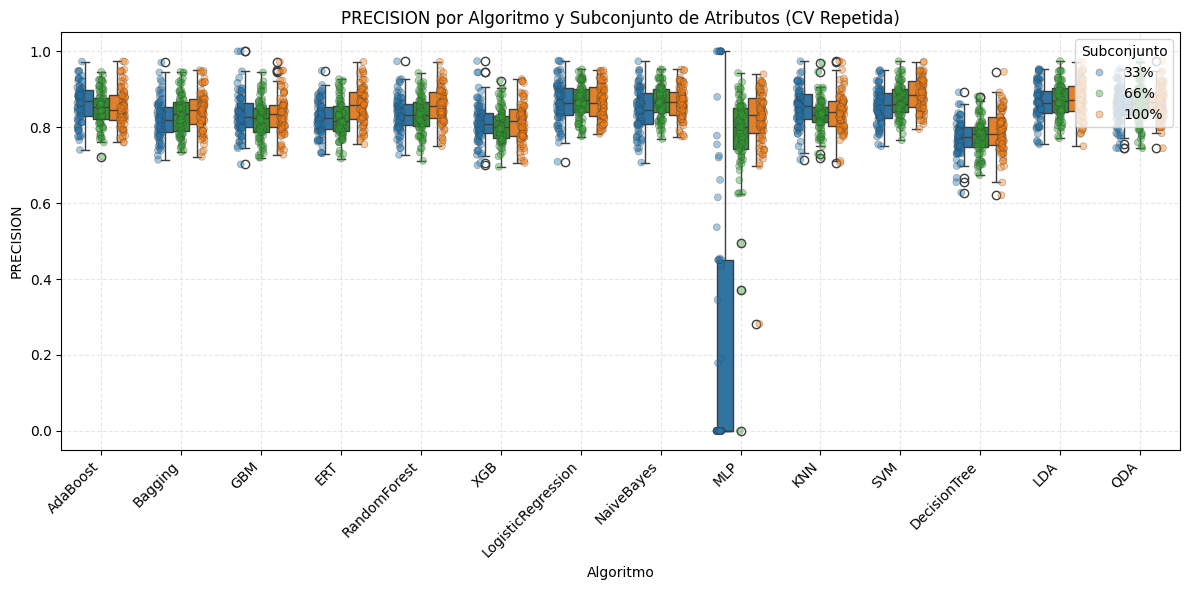

C:\Users\americasys\AppData\Local\Temp\ipykernel_28976\686355642.py:64: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


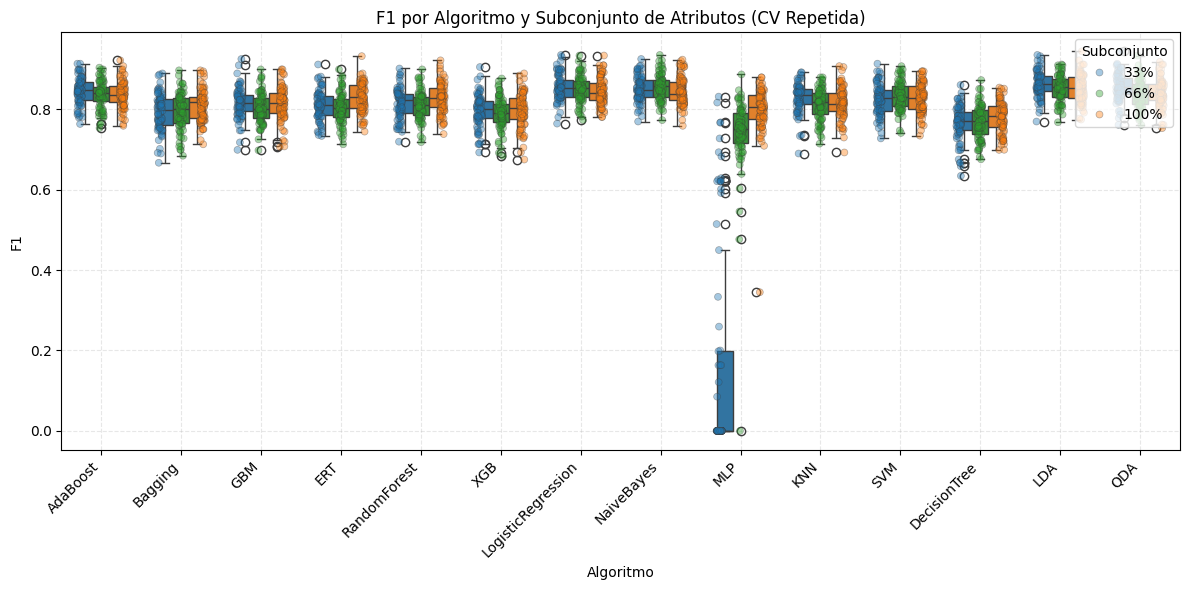

C:\Users\americasys\AppData\Local\Temp\ipykernel_28976\686355642.py:64: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


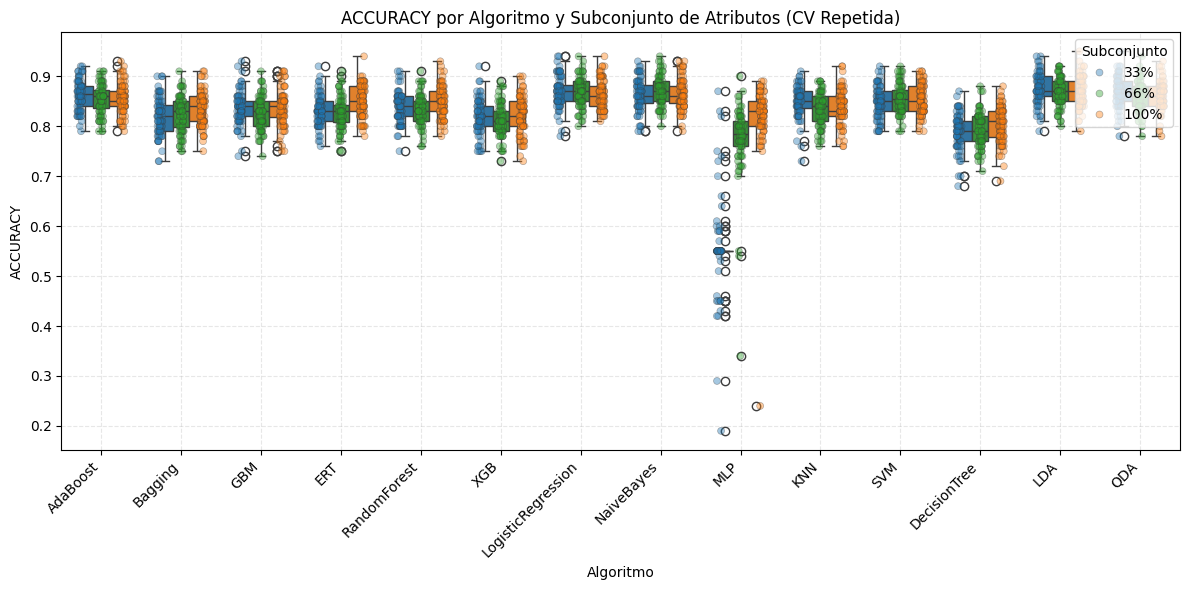

C:\Users\americasys\AppData\Local\Temp\ipykernel_28976\686355642.py:64: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


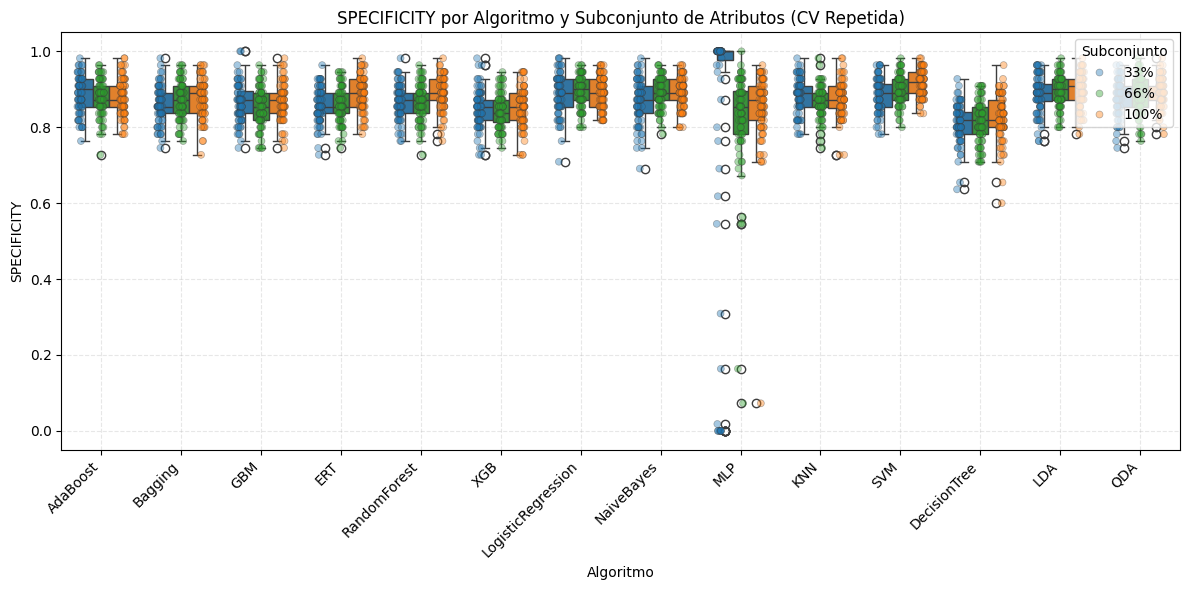

C:\Users\americasys\AppData\Local\Temp\ipykernel_28976\686355642.py:64: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


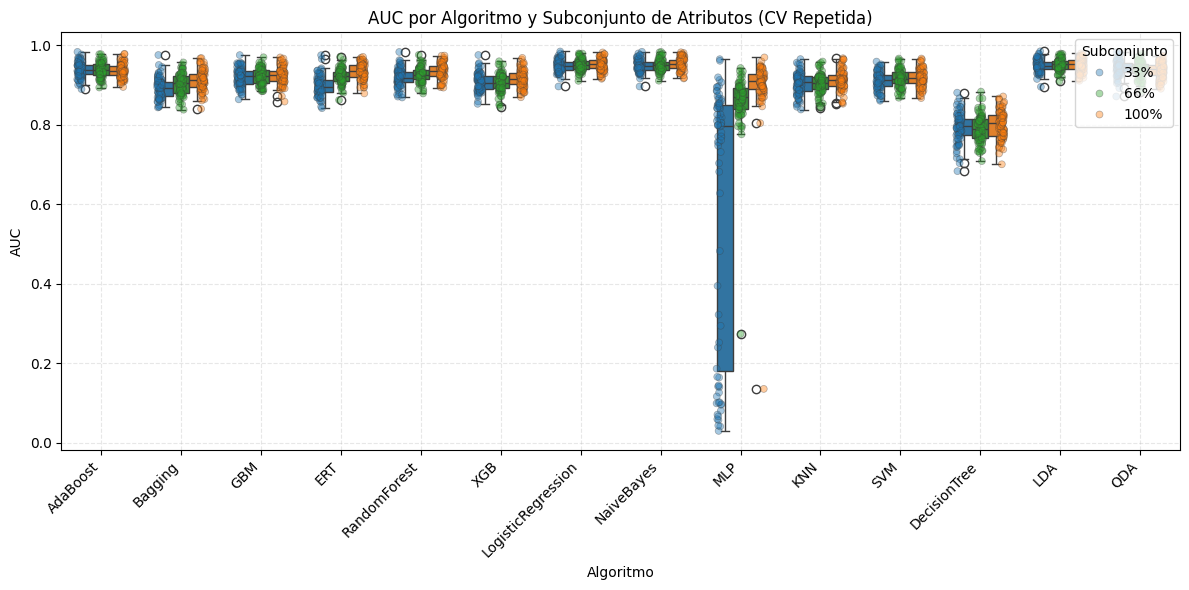

In [17]:
# ============================
# Paso 10: Evaluación con subconjuntos 33%, 66%, 100% basados en ranking
# ============================

# Asegurar que el DataFrame esté listo
df_encoded = df.copy()

# Definir subconjuntos de atributos de acuerdo al ranking
total_features = ranking_df.shape[0]
top_33 = ranking_df.sort_values("Rank").head(int(total_features * 0.33)).index.tolist()
top_66 = ranking_df.sort_values("Rank").head(int(total_features * 0.66)).index.tolist()
top_100 = ranking_df.sort_values("Rank").index.tolist()

datasets = {
    '33%': df_encoded[top_33 + ['target']],
    '66%': df_encoded[top_66 + ['target']],
    '100%': df_encoded[top_100 + ['target']]
}

# Colores para los gráficos
dataset_colors = {'33%': '#1f77b4', '66%': '#2ca02c', '100%': '#ff7f0e'}

results_all_cv = []

# Evaluar cada subconjunto con validación cruzada repetida
for name, dataset in datasets.items():
    X = dataset.drop('target', axis=1).astype('float64')
    y = dataset['target']

    # Codificar target si es categórico
    y_encoded = LabelEncoder().fit_transform(y)

    for model_label, model in models.items():
        print(f"Evaluando {model_label} con subconjunto {name}")
        df_metrics = repeated_cv_metrics(
            model, X, y_encoded, n_repeats=20, n_splits=4
        )
        df_metrics['Algorithm'] = model_label
        df_metrics['attr'] = name
        results_all_cv.append(df_metrics)

# Consolidar resultados en un solo DataFrame
df_results_all_cv = pd.concat(results_all_cv, ignore_index=True)

# ============================
# Gráficos comparativos por métrica
# ============================

for metric in ['recall', 'precision', 'f1', 'accuracy', 'specificity', 'auc']:
    if metric not in df_results_all_cv.columns:
        print(f"⚠️ Métrica {metric} no encontrada en df_results_all_cv, se omite.")
        continue

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        x='Algorithm',
        y=metric,
        hue='attr',
        data=df_results_all_cv,
        palette=dataset_colors,
        dodge=True,
        width=0.6
    )
    sns.stripplot(
        x='Algorithm',
        y=metric,
        hue='attr',
        data=df_results_all_cv,
        palette=dataset_colors,
        dodge=True,
        marker='o',
        edgecolor='gray',
        alpha=0.4,
        linewidth=0.5,
        ax=ax
    )

    # Evitar leyenda duplicada
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title='Subconjunto', loc='upper right')

    plt.title(f'{metric.upper()} por Algoritmo y Subconjunto de Atributos (CV Repetida)')
    plt.xlabel('Algoritmo')
    plt.ylabel(metric.upper())
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [18]:
""" # ===============================
# Paso 10.1: Evaluación con subconjuntos y visualización tipo boxplot - Métrica Accuracy (con CV repetida)
# ===============================

from sklearn.model_selection import RepeatedStratifiedKFold

# Función auxiliar para CV repetida
def repeated_cv_metrics(model, X, y, model_label, subset_name, n_splits=5, n_repeats=10):
    rkf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    rows = []

    for train_idx, test_idx in rkf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)

        try:
            y_pred_prob = model.predict_proba(X_valid)[:, 1]
        except AttributeError:
            y_pred_prob = y_pred

        cm = confusion_matrix(y_valid, y_pred)
        sensitivity = recall_score(y_valid, y_pred)
        specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
        precision = precision_score(y_valid, y_pred)
        f1 = f1_score(y_valid, y_pred)
        accuracy = accuracy_score(y_valid, y_pred)
        try:
            auc = roc_auc_score(y_valid, y_pred_prob)
        except:
            auc = np.nan

        rows.append({
            "Algorithm": model_label,
            "Subset": subset_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Sensitivity": sensitivity,
            "Specificity": specificity,
            "F1": f1,
            "AUC": auc
        })

    return pd.DataFrame(rows)


# ===============================
# Construcción de subconjuntos desde ranking
# ===============================
ranking_sorted = ranking_df.sort_values("Rank")
total_features = len(ranking_sorted)

top_33 = ranking_sorted.head(int(total_features * 0.33)).index.tolist()
top_66 = ranking_sorted.head(int(total_features * 0.66)).index.tolist()
top_100 = ranking_sorted.index.tolist()

df_33 = df_vis[top_33 + ['target']]
df_66 = df_vis[top_66 + ['target']]
df_100 = df_vis[top_100 + ['target']]

datasets = {
    '33%': df_33,
    '66%': df_66,
    '100%': df_100
} 

# ===============================
# Evaluación con CV repetida
# ===============================
results_all = []

for name, dataset in datasets.items():
    X_eval = pd.get_dummies(dataset.drop('target', axis=1), drop_first=True).astype('float64')
    y_eval = dataset['target'].astype(int)

    for model_label, model in models.items():
        print(f"Evaluando {model_label} en subconjunto {name}...")
        df_metrics = repeated_cv_metrics(model, X_eval, y_eval, model_label, name, n_splits=5, n_repeats=10)
        results_all.append(df_metrics)

df_results_all = pd.concat(results_all, ignore_index=True)

# ===============================
# Visualización tipo panel (boxplot horizontal para Accuracy)
# ===============================
import matplotlib.gridspec as gridspec

metric = 'Accuracy'
sorted_labels = df_results_all.groupby(['Subset','Algorithm'])[metric].mean().sort_values().index

# Figura dividida en 2 columnas
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

half = len(sorted_labels) // 2

for i, ax in enumerate(axs):
    subset_labels = sorted_labels[half * i:half * (i + 1)]
    subset = df_results_all[
        df_results_all.set_index(['Subset','Algorithm']).index.isin(subset_labels)
    ]

    sns.boxplot(
        data=subset,
        y='Algorithm',
        x=metric,
        hue='Subset',
        orient='h',
        ax=ax,
        palette={'33%': 'red', '66%': 'green', '100%': 'blue'}
    )

    ax.set_xlim(0.65, 1.0)
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('')
    ax.set_title(f'Accuracy por modelo y conjunto ({"Panel Izquierdo" if i == 0 else "Panel Derecho"})')
    ax.legend_.remove()

plt.tight_layout()
plt.show()

""" 
# ===============================
# Paso 10.1: Evaluación con subconjuntos y visualización tipo boxplot - Accuracy
# ===============================

import matplotlib.gridspec as gridspec

# Crear columna combinada (Subset.Algorithm) y colores
df_results_all['Label'] = df_results_all['Subset'] + '.' + df_results_all['Algorithm']
df_results_all['Color'] = df_results_all['Subset'].map({'33%': 'red', '66%': 'green', '100%': 'blue'})

# Ordenar etiquetas según Accuracy promedio
metric = 'Accuracy'
sorted_labels = df_results_all.groupby('Label')[metric].mean().sort_values().index

# Figura en dos paneles
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

half = len(sorted_labels) // 2

for i, ax in enumerate(axs):
    labels = sorted_labels[half * i:half * (i + 1)]
    subset = df_results_all[df_results_all['Label'].isin(labels)]
    
    sns.boxplot(
        data=subset,
        y='Label',
        x=metric,
        hue='Subset',
        orient='h',
        ax=ax,
        palette={'33%': 'red', '66%': 'green', '100%': 'blue'}
    )
    
    ax.set_xlim(0.65, 1.0)
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('')
    ax.set_title(f'Accuracy por modelo y conjunto ({"Panel Izquierdo" if i == 0 else "Panel Derecho"})')
    ax.legend_.remove()

plt.tight_layout()
plt.show()



NameError: name 'df_results_all' is not defined

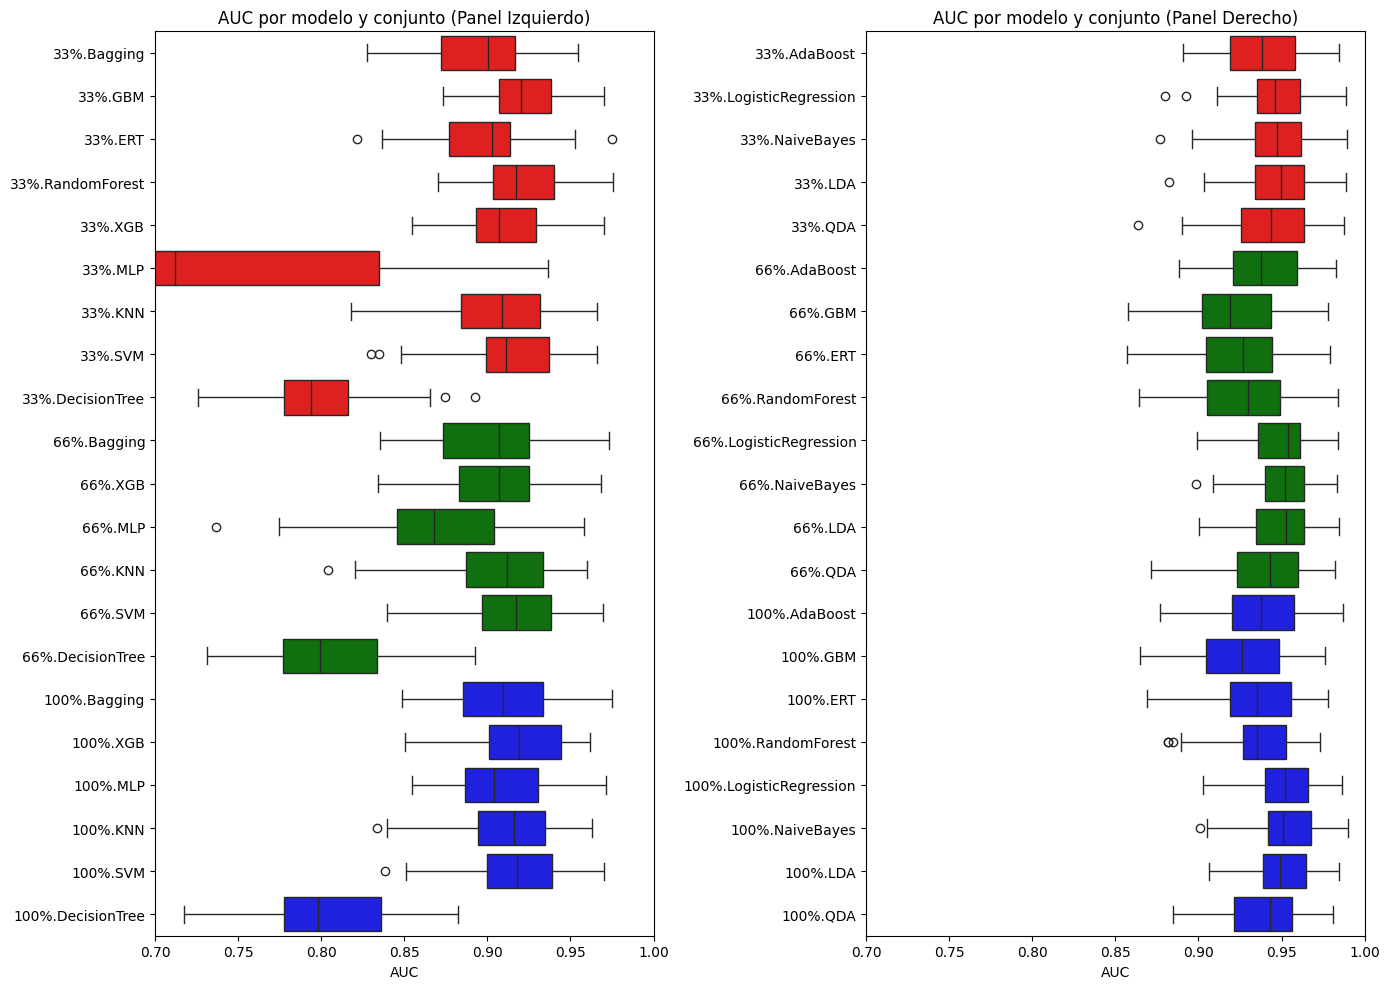

In [ ]:
# Paso 10.2: Boxplot de AUC por modelo y conjunto de datos

import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurarse de que estas columnas estén generadas correctamente
df_results_all['Label'] = df_results_all['Subset'] + '.' + df_results_all['Algorithm']
df_results_all['Color'] = df_results_all['Subset'].map({'33%': 'red', '66%': 'green', '100%': 'blue'})

# Ordenar etiquetas por promedio de AUC
metric = 'AUC'
sorted_labels = df_results_all.groupby('Label')[metric].mean().sort_values().index

# Crear figura en dos columnas (paneles)
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

half = len(sorted_labels) // 2

for i, ax in enumerate(axs):
    labels = sorted_labels[half * i:half * (i + 1)]
    subset = df_results_all[df_results_all['Label'].isin(labels)]
    sns.boxplot(
        data=subset,
        y='Label',
        x=metric,
        hue='Subset',
        orient='h',
        ax=ax,
        palette={'33%': 'red', '66%': 'green', '100%': 'blue'}
    )
    ax.set_xlim(0.7, 1.0)
    ax.set_xlabel('AUC')
    ax.set_ylabel('')
    ax.set_title(f'AUC por modelo y conjunto ({"Panel Izquierdo" if i == 0 else "Panel Derecho"})')
    ax.legend_.remove()

plt.tight_layout()
plt.show()

## Análisis de Curvas de Rashomon y Complejidad de Modelos en Admision Predict

En esta sección se incorpora el análisis de **curvas de Rashomon**, 
la evaluación de la **complejidad del modelo**, y la representación de un **frente de Pareto** entre precisión y simplicidad del sistema.

El objetivo es observar si modelos más simples pueden alcanzar niveles similares de rendimiento y así facilitar la explicabilidad.


In [ ]:
import time
import warnings
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')

# Preparar versiones del dataset con diferentes números de atributos
feature_sets = {
    'all': X.columns.tolist(),
    'top5': ranking_df.sort_values("Rank").head(5).index.tolist(),
    'top3': ranking_df.sort_values("Rank").head(3).index.tolist()
}

rashomon_results = []
epsilon = 0.01  # 1% del mejor AUC

for subset_name, features in feature_sets.items():
    X_sub = X[features]
    X_train_r, X_valid_r, y_train_r, y_valid_r = train_test_split(X_sub, y, test_size=0.25, random_state=42)

    subset_scores = []
    best_auc = 0

    for model_label, model in models.items():
        try:
            start = time.time()
            model.fit(X_train_r, y_train_r)
            train_time = time.time() - start

            y_pred = model.predict(X_valid_r)
            try:
                y_prob = model.predict_proba(X_valid_r)[:, 1]
            except:
                y_prob = y_pred

            auc = roc_auc_score(y_valid_r, y_prob)
            best_auc = max(best_auc, auc)

            if hasattr(model, 'n_estimators'):
                complexity = model.n_estimators
            elif hasattr(model, 'coef_'):
                complexity = model.coef_.shape[1]
            elif hasattr(model, 'hidden_layer_sizes'):
                complexity = sum(model.hidden_layer_sizes)
            elif hasattr(model, 'tree_'):
                complexity = model.tree_.max_depth
            else:
                complexity = train_time

            subset_scores.append({
                'Subset': subset_name,
                'Model': model_label,
                'AUC': auc,
                'TrainingTime': train_time,
                'Complexity': complexity
            })
        except Exception as e:
            print(f'Error with {model_label} on {subset_name}:', e)

    rashomon_models = [s for s in subset_scores if s['AUC'] >= (best_auc - epsilon)]
    rashomon_volume = len(rashomon_models)

    for score in subset_scores:
        score['BestAUC'] = best_auc
        score['RashomonVolume'] = rashomon_volume
        score['WithinEpsilon'] = score['AUC'] >= (best_auc - epsilon)

    rashomon_results.extend(subset_scores)

rashomon_df = pd.DataFrame(rashomon_results)
rashomon_df

Subset               Model       AUC  TrainingTime  Complexity   BestAUC  \
0     all            AdaBoost  0.972716      0.093154   50.000000  0.981397   
1     all             Bagging  0.938198      0.021275   10.000000  0.981397   
2     all                 GBM  0.963621      0.120543  100.000000  0.981397   
3     all                 ERT  0.960728      0.113297  100.000000  0.981397   
4     all        RandomForest  0.965068      0.141185  100.000000  0.981397   
5     all                 XGB  0.956594      0.090320         NaN  0.981397   
6     all  LogisticRegression  0.977677      0.060305    7.000000  0.981397   
7     all          NaiveBayes  0.981397      0.000000    0.000000  0.981397   
8     all                 MLP  0.957007      0.131932  100.000000  0.981397   
9     all                 KNN  0.939644      0.000000    0.000000  0.981397   
10    all                 SVM  0.929310      0.020849    0.020849  0.981397   
11    all        DecisionTree  0.890864      0.000000   15.000000  0.981397   
12    all                 LDA  0.975610      0.006925    7.000000  0.981397   
13    all                 QDA  0.973543      0.000000    0.000000  0.981397   
14   top5            AdaBoost  0.974370      0.084115   50.000000  0.980157   
15   top5             Bagging  0.953286      0.018706   10.000000  0.980157   
16   top5                 GBM  0.965688      0.124758  100.000000  0.980157   
17   top5                 ERT  0.964655      0.106113  100.000000  0.980157   
18   top5        RandomForest  0.968375      0.138883  100.000000  0.980157   
19   top5                 XGB  0.953286      0.071763         NaN  0.980157   
20   top5  LogisticRegression  0.976437      0.013850    5.000000  0.980157   
21   top5          NaiveBayes  0.980157      0.000000    0.000000  0.980157   
22   top5                 MLP  0.923936      0.209031  100.000000  0.980157   
23   top5                 KNN  0.945225      0.000000    0.000000  0.980157   
24   top5                 SVM  0.929310      0.015633    0.015633  0.980157   
25   top5        DecisionTree  0.870194      0.000000   12.000000  0.980157   
26   top5                 LDA  0.976437      0.006570    5.000000  0.980157   
27   top5                 QDA  0.970236      0.000000    0.000000  0.980157   
28   top3            AdaBoost  0.966102      0.085244   50.000000  0.967342   
29   top3             Bagging  0.966515      0.018860   10.000000  0.967342   
30   top3                 GBM  0.957420      0.111165  100.000000  0.967342   
31   top3                 ERT  0.952460      0.106185  100.000000  0.967342   
32   top3        RandomForest  0.964241      0.140832  100.000000  0.967342   
33   top3                 XGB  0.954940      0.062552         NaN  0.967342   
34   top3  LogisticRegression  0.964862      0.007258    3.000000  0.967342   
35   top3          NaiveBayes  0.959074      0.000927    0.000927  0.967342   
36   top3                 MLP  0.821414      0.118227  100.000000  0.967342   
37   top3                 KNN  0.930963      0.000000    0.000000  0.967342   
38   top3                 SVM  0.927656      0.013720    0.013720  0.967342   
39   top3        DecisionTree  0.874122      0.006973   12.000000  0.967342   
40   top3                 LDA  0.967342      0.000000    3.000000  0.967342   
41   top3                 QDA  0.961968      0.000000    0.000000  0.967342   

    RashomonVolume  WithinEpsilon  
0                5           True  
1                5          False  
2                5          False  
3                5          False  
4                5          False  
5                5          False  
6                5           True  
7                5           True  
8                5          False  
9                5          False  
10               5          False  
11               5          False  
12               5           True  
13               5           True  
14               5           True  
15               5          F

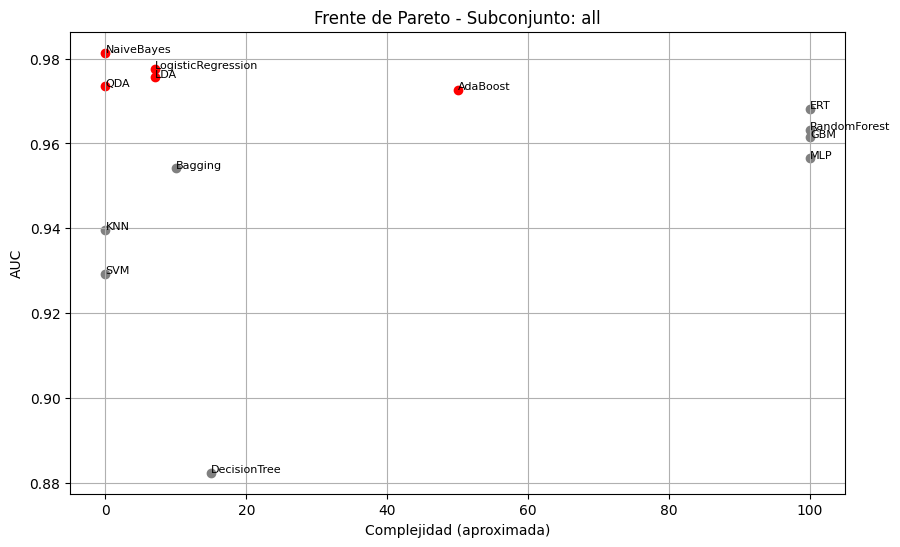

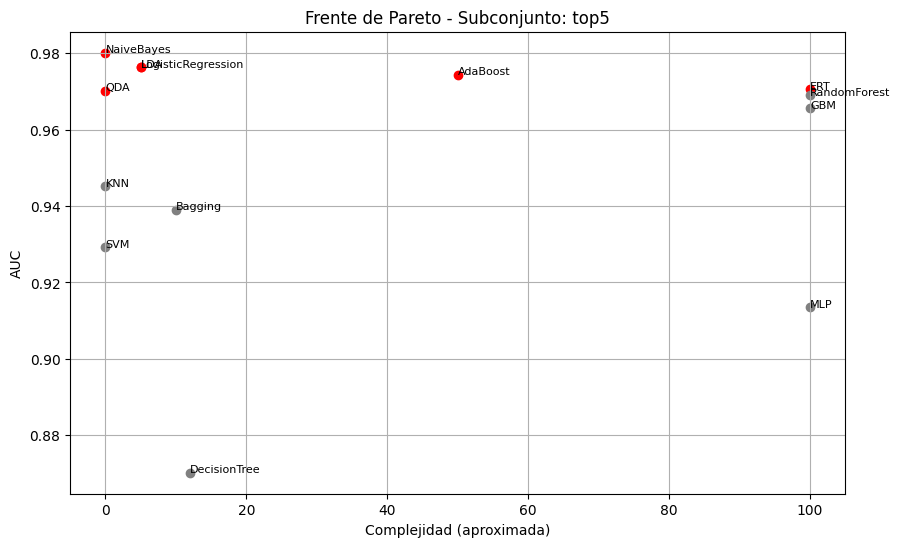

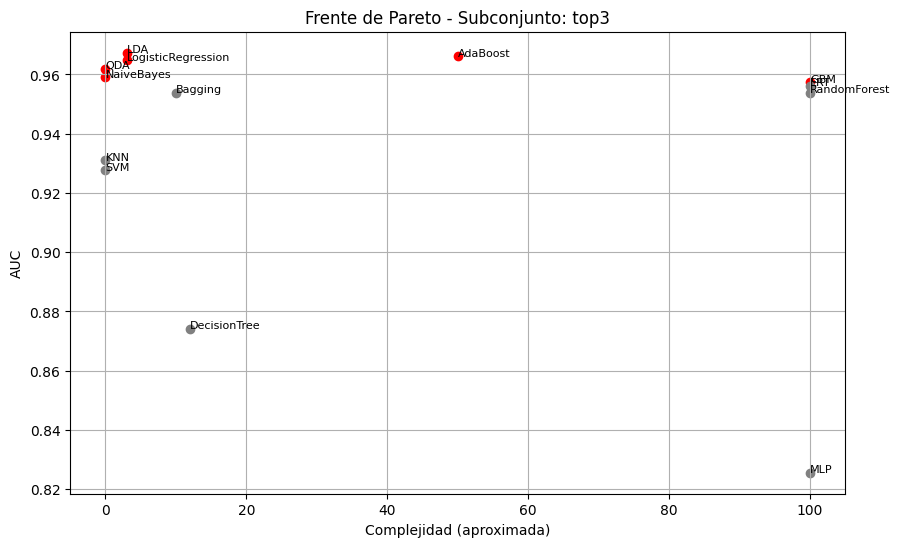

In [ ]:
for subset_name in rashomon_df['Subset'].unique():
    subset_data = rashomon_df[rashomon_df['Subset'] == subset_name]

    plt.figure(figsize=(10, 6))
    for _, row in subset_data.iterrows():
        color = 'red' if row['WithinEpsilon'] else 'gray'
        plt.scatter(row['Complexity'], row['AUC'], label=row['Model'], color=color)
        plt.text(row['Complexity'], row['AUC'], row['Model'], fontsize=8)

    plt.title(f"Frente de Pareto - Subconjunto: {subset_name}")
    plt.xlabel("Complejidad (aproximada)")
    plt.ylabel("AUC")
    plt.grid(True)
    plt.show()


In [ ]:
# Definir subconjuntos basados en porcentajes del ranking de atributos
total_features = ranking_df.shape[0]
top_33_count = max(1, int(total_features * 0.33))
top_66_count = max(1, int(total_features * 0.66))

feature_sets = {
    'top33': ranking_df.sort_values("Rank").head(top_33_count).index.tolist(),
    'top66': ranking_df.sort_values("Rank").head(top_66_count).index.tolist(),
    'top100': ranking_df.sort_values("Rank").index.tolist()
}

rashomon_results = []
epsilon = 0.01  # 1% del mejor AUC

for subset_name, features in feature_sets.items():
    X_sub = X[features]
    X_train_r, X_valid_r, y_train_r, y_valid_r = train_test_split(X_sub, y, test_size=0.25, random_state=42)

    subset_scores = []
    best_auc = 0

    for model_label, model in models.items():
        try:
            start = time.time()
            model.fit(X_train_r, y_train_r)
            train_time = time.time() - start

            y_pred = model.predict(X_valid_r)
            try:
                y_prob = model.predict_proba(X_valid_r)[:, 1]
            except:
                y_prob = y_pred

            auc = roc_auc_score(y_valid_r, y_prob)
            best_auc = max(best_auc, auc)

            if hasattr(model, 'n_estimators'):
                complexity = model.n_estimators
            elif hasattr(model, 'coef_'):
                complexity = model.coef_.shape[1]
            elif hasattr(model, 'hidden_layer_sizes'):
                complexity = sum(model.hidden_layer_sizes)
            elif hasattr(model, 'tree_'):
                complexity = model.tree_.max_depth
            else:
                complexity = train_time

            subset_scores.append({
                'Subset': subset_name,
                'Model': model_label,
                'AUC': auc,
                'TrainingTime': train_time,
                'Complexity': complexity
            })
        except Exception as e:
            print(f'Error with {model_label} on {subset_name}:', e)

    rashomon_models = [s for s in subset_scores if s['AUC'] >= (best_auc - epsilon)]
    rashomon_volume = len(rashomon_models)

    for score in subset_scores:
        score['BestAUC'] = best_auc
        score['RashomonVolume'] = rashomon_volume
        score['WithinEpsilon'] = score['AUC'] >= (best_auc - epsilon)

    rashomon_results.extend(subset_scores)

rashomon_df = pd.DataFrame(rashomon_results)


In [ ]:
# Crear resumen por subconjunto
summary = rashomon_df.groupby('Subset').agg({
    'RashomonVolume': 'first',
    'AUC': ['mean', 'max'],
    'Complexity': 'mean'
}).reset_index()

summary.columns = ['Subset', 'RashomonVolume', 'AUC_Mean', 'AUC_Max', 'Complexity_Mean']
summary = summary.sort_values("Subset")

# Mostrar con formato
display(summary.style.format({
    "AUC_Mean": "{:.3f}",
    "AUC_Max": "{:.3f}",
    "Complexity_Mean": "{:.1f}"
}))

In [ ]:
# Exportar resumen a CSV
summary.to_csv("rashomon_summary.csv", index=False)
print("Resumen exportado como 'rashomon_summary_HeartDisease.csv'")

Resumen exportado como 'rashomon_summary_HeartDisease.csv'


In [ ]:
# Exportar todos los resultados individuales a CSV
rashomon_df.to_csv("rashomon_model_results_heartDisease.csv", index=False)
print("Resultados detallados exportados como 'rashomon_model_results_HeartDisease.csv'")

Resultados detallados exportados como 'rashomon_model_results_HeartDisease.csv'


In [ ]:
# Identificar modelos en el frente de Pareto (AUC vs. Complejidad)
def is_pareto_efficient(df, perf_col="AUC", cost_col="Complexity"):
    is_efficient = []
    for i, row_i in df.iterrows():
        dominated = False
        for j, row_j in df.iterrows():
            if (
                (row_j[perf_col] >= row_i[perf_col])
                and (row_j[cost_col] <= row_i[cost_col])
                and ((row_j[perf_col] > row_i[perf_col]) or (row_j[cost_col] < row_i[cost_col]))
            ):
                dominated = True
                break
        is_efficient.append(not dominated)
    return is_efficient

# Aplicar por subconjunto
pareto_df_list = []
for subset in rashomon_df['Subset'].unique():
    df_subset = rashomon_df[rashomon_df['Subset'] == subset].copy()
    df_subset['ParetoFront'] = is_pareto_efficient(df_subset)
    pareto_df_list.append(df_subset)

pareto_df = pd.concat(pareto_df_list)

# Exportar modelos en el frente de Pareto
pareto_df[pareto_df['ParetoFront']].to_csv("rashomon_pareto_models.csv", index=False)
print("Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'")

Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'


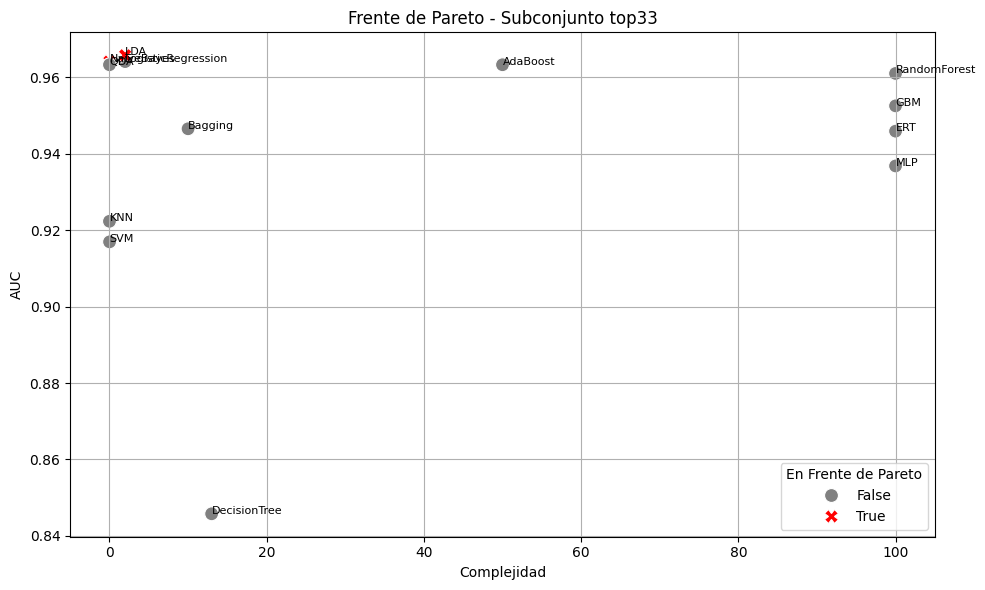

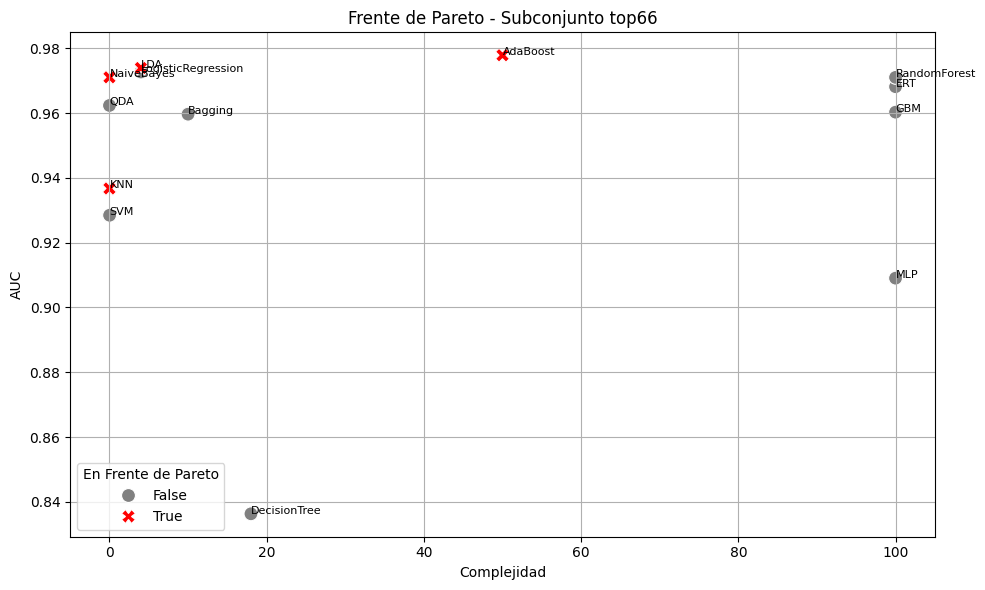

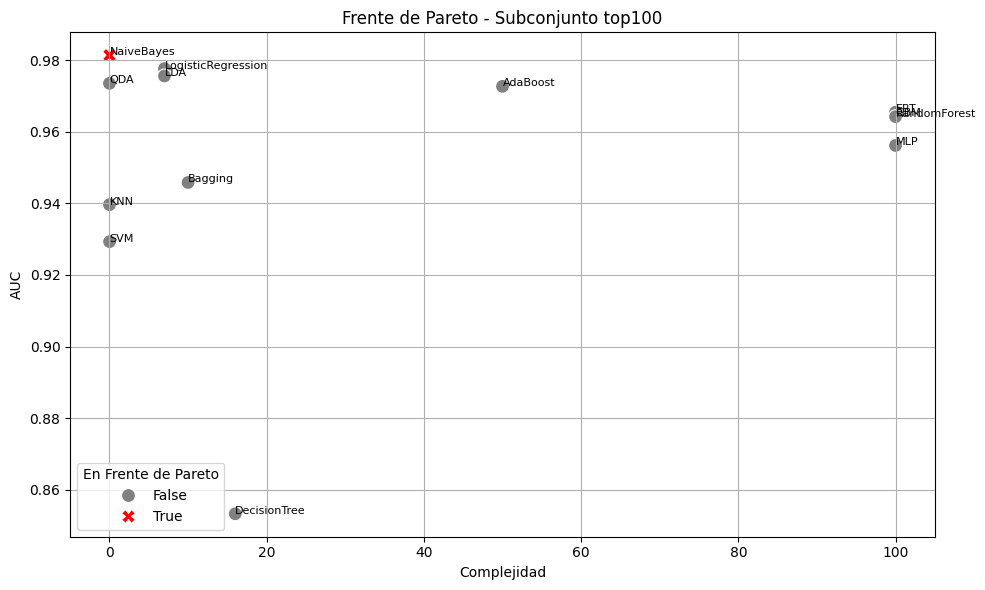

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualización del frente de Pareto para cada subconjunto
for subset in pareto_df['Subset'].unique():
    data = pareto_df[pareto_df['Subset'] == subset]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='Complexity', y='AUC',
        hue='ParetoFront',
        style='ParetoFront',
        palette={True: 'red', False: 'gray'},
        data=data,
        s=100
    )
    for _, row in data.iterrows():
        plt.text(row['Complexity'], row['AUC'], row['Model'], fontsize=8)

    plt.title(f'Frente de Pareto - Subconjunto {subset}')
    plt.xlabel('Complejidad')
    plt.ylabel('AUC')
    plt.legend(title='En Frente de Pareto')
    plt.grid(True)
    plt.tight_layout()
    plt.show()